In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_colwidth', 200)

# import data

In [2]:
df_hist = pd.read_csv(r'.\csv\trapnet_biologicaldetailing_202302231329.csv', low_memory=False)
df_spec = pd.read_csv(r'.\csv\trapnet_specimen_202302231329.csv', low_memory=False)

# historical data without trivial fields (fields with only one entry)
unmatchable_hist = ['created_at', 'updated_at']
df_hist = df_hist.drop(unmatchable_hist, axis=1).loc[:, df_hist.nunique() > 1]
hist_sample_id_list = sorted(list(df_hist.sample_id.unique()))

# all species in historical data are 79 (atlantic salmon)
unmatchable_spec = ['created_at', 'updated_at', 'created_by_id', 'updated_by_id']
df_spec = df_spec[(df_spec.species_id==79) & (df_spec.sample_id.isin(hist_sample_id_list))].reset_index(drop=True)
df_spec = df_spec.drop(unmatchable_spec, axis=1).loc[:, df_spec.nunique() > 1]

# cast to int where appropriate
df_hist[['fork_length', 'sex_id']] = df_hist[['fork_length', 'sex_id']].astype('Int64')
df_spec[['fork_length', 'sex_id']] = df_spec[['fork_length', 'sex_id']].astype('Int64')

# archived fish data
df_arch = pd.read_csv(r'.\csv\fish_data.csv', low_memory=False)
df_arch['DATETIME'] = pd.to_datetime(df_arch['SITE_EVENT_DATE'].str.split(' ', expand=True)[0], format='%d/%m/%Y')
df_arch['old_id'] = 'GD_' + df_arch['GD_ID'].astype(str)
df_arch = df_arch[['old_id', 'DATETIME'] + [x for x in df_arch.columns if x not in ['SITE_EVENT_DATE', 'DATETIME', 'old_id']]]

In [3]:
# create a 'matching id' for matching distinctive fish characteristics

df_hist['matching_id'] = df_hist['sample_id'].astype(str) + df_hist['fork_length'].fillna(0).astype(str) + df_hist['weight'].fillna(0).astype(str) + df_hist['sex_id'].fillna(0).astype(str)
df_hist['matching_id'] = df_hist['matching_id'].str.replace('.', '_', regex=False)

df_spec['matching_id'] = df_spec['sample_id'].astype(str) + df_spec['fork_length'].fillna(0).astype(str) + df_spec['weight'].fillna(0).astype(str) + df_spec['sex_id'].fillna(0).astype(str)
df_spec['matching_id'] = df_spec['matching_id'].str.replace('.', '_', regex=False)

df_arch['arch_matching_id'] = '____' + df_arch['FORK_LENGTH'].fillna(0).round(0).astype('Int64').astype(str) + df_arch['WEIGHT'].fillna(0).astype(str) + df_arch['SEX'].fillna('U').map({'U':0,'M':1,'F':2}).astype(str)
df_arch['arch_matching_id'] = df_arch['arch_matching_id'].str.replace('.', '_', regex=False)

In [4]:
# combine historical and specimen data noting which sample they come from
#  start by assuming these are separate fish (no overlap), and confirm

all_fish = pd.concat([
    df_hist[['id', 'old_id', 'sample_id', 'matching_id']].rename({'id':'hist_id'}, axis=1),
    df_spec[['id', 'old_id', 'sample_id', 'matching_id']].rename({'id':'spec_id'}, axis=1)  # only samples that contain historical fishes are included in df_spec
], axis=0)[['old_id', 'spec_id', 'hist_id', 'sample_id', 'matching_id']]
all_fish.spec_id = all_fish.spec_id.astype('Int64')
all_fish.hist_id = all_fish.hist_id.astype('Int64')

# size of data
all_fish.shape

(102190, 5)

In [5]:
# merge with archived data

all_fish = pd.merge(all_fish, df_arch[['old_id', 'arch_matching_id']], on='old_id', how='left')

# check fish detail matches using matching id, and count the number of entries matching the archived data with spec & hist data
all_fish['fish_details_match'] = all_fish['matching_id'].str[4:] == all_fish['arch_matching_id'].str[4:]
all_fish['num_found_in_archive'] = all_fish[['spec_id', 'hist_id']].count(axis=1)

all_fish.head()

,old_id,spec_id,hist_id,sample_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
0,GD_1,<NA>,69352,4390,4390340_51,____340_51,True,1
1,GD_2,<NA>,69353,4390,4390340_62,____340_62,True,1
2,GD_3,<NA>,69354,4390,4390360_51,____360_51,True,1
3,GD_4,<NA>,69355,4390,4390360_61,____360_61,True,1
4,GD_5,<NA>,69356,4390,4390361_31,____361_31,True,1


# is there overlap between df_spec and df_hist? (no)
# how many fish characteristics match between dm_apps and archived data? (all of them)
# do these fish have matching length, weight, sex? (yes, all of them)
# how many fish are matched in archive? (all of them)

In [6]:
all_fish.describe(percentiles=[])

,spec_id,hist_id,sample_id,num_found_in_archive
count,74666.000,27524.000,102190.000,102190.000
mean,2326088.809,83113.500,6511.726,1.000
std,74105.150,7945.639,1264.222,0.000
min,1708668.000,69352.000,4390.000,1.000
50%,2333117.500,83113.500,7193.000,1.000
max,2430212.000,96875.000,8001.000,1.000


In [7]:
# every single fish matches
all_fish.fish_details_match.value_counts()

True    102190
Name: fish_details_match, dtype: int64

In [8]:
# every single fish accounted for in archived data
sum(all_fish.arch_matching_id.isnull())

0

# does the number of duplicated fish in df_spec match the number of fish in df_hist? (no)
* ie, could the historical fish be part of the specimen fish that have used duplicated old_id? (CATCH_FREQUENCY > 1)

In [9]:
# most fish in df_spec are duplicates
df_spec.old_id.nunique()

18992

In [10]:
# every single fish in df_hist is a singleton
df_hist.old_id.nunique()

27524

In [11]:
# do the duplicates in df_spec account for df_hist?

df_grouped = all_fish.groupby(['sample_id', 'old_id']).count()
df_duplicates = df_grouped[df_grouped.spec_id>1].reset_index()
duplicated_fishes = list(df_duplicates.old_id)

df_duplicates.head()

,sample_id,old_id,spec_id,hist_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
0,4404,GD_202,6,0,6,6,6,6
1,4404,GD_204,4,0,4,4,4,4
2,4404,GD_205,4,0,4,4,4,4
3,4404,GD_206,2,0,2,2,2,2
4,4404,GD_207,2,0,2,2,2,2


In [12]:
df_dupes_per_sample = df_duplicates.groupby('sample_id').count()[['old_id']].reset_index().rename({'old_id':'number_duplicates'}, axis=1).astype('Int64')
df_hist_per_sample = df_hist.groupby('sample_id').count()[['id']].reset_index().rename({'id':'number_historical'}, axis=1)
df_hist_v_dupes = pd.merge(df_dupes_per_sample, df_hist_per_sample, on='sample_id', how='outer')

df_hist_v_dupes.sample(10)

,sample_id,number_duplicates,number_historical
317,5589,15,38
264,5376,9,11
188,5278,17,14
143,4646,28,10
527,7663,19,134
184,5272,10,29
115,4606,2,5
274,5389,31,30
234,5344,37,28
242,5352,9,30


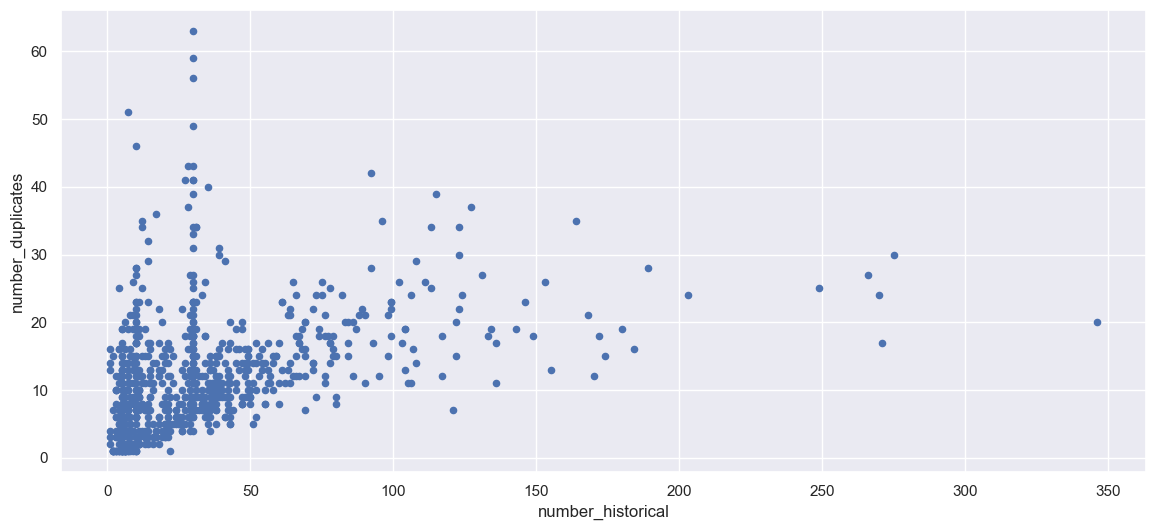

In [13]:
# historical and duplicated old_id do not look related

df_hist_v_dupes.plot(kind='scatter', x='number_historical', y='number_duplicates', figsize=(14, 6));

# does CATCH_FREQUENCY  from df_arch account for all duplicates? (yes)

In [14]:
df_catch_frequency = pd.merge(
    df_duplicates[['sample_id', 'old_id', 'spec_id']],
    df_arch[['old_id', 'CATCH_FREQUENCY']], 
    on='old_id',
    how='left'
)
df_catch_frequency.head()

,sample_id,old_id,spec_id,CATCH_FREQUENCY
0,4404,GD_202,6,6
1,4404,GD_204,4,4
2,4404,GD_205,4,4
3,4404,GD_206,2,2
4,4404,GD_207,2,2


In [15]:
# matches exactly
sum(df_catch_frequency.spec_id != df_catch_frequency.CATCH_FREQUENCY)

0

# is the catch frequency of df_hist always 1? (yes)

In [16]:
df_catch_frequency_historical = pd.merge(
    df_hist[['old_id']],
    df_arch[['old_id', 'CATCH_FREQUENCY']], 
    on='old_id',
    how='left'
)
df_catch_frequency_historical.head()

,old_id,CATCH_FREQUENCY
0,GD_1,1
1,GD_2,1
2,GD_3,1
3,GD_4,1
4,GD_5,1


In [17]:
# yes
sum(df_catch_frequency_historical.CATCH_FREQUENCY!=1)

0

# are there ever missing archived data that isn't in all_fish? (no)
* on one date: 1985-08-19
    * why were these excluded? are they different?
        * they are included but don't include historical data in their samples.
        * therefore, they are all accounted for

In [18]:
all_fish_old_ids = list(all_fish.old_id.unique())
len(all_fish_old_ids)

46516

In [19]:
df_match_all_fish = df_arch[df_arch.old_id.isin(all_fish_old_ids)].groupby(['DATETIME', 'SITE']).count().reset_index()[['DATETIME', 'SITE']]

In [20]:
df_unmatched = df_arch[~df_arch.old_id.isin(all_fish_old_ids)].copy()  # only unmatched
df_unmatched = df_unmatched[df_unmatched.SPECIES_ITIS_CODE=='161996']  # only salmon

datetimes_in_all_fish = list(df_arch[df_arch.old_id.isin(all_fish_old_ids)].DATETIME.unique())
df_unmatched = df_unmatched[df_unmatched.DATETIME.isin(datetimes_in_all_fish)]  # exclude non-matching dates

df_unmatched.shape

(13593, 33)

In [21]:
datetimes_in_still_unmatched = list(df_unmatched.DATETIME.unique())
len(datetimes_in_still_unmatched)

186

In [22]:
for date in datetimes_in_still_unmatched:
    temp_no = df_unmatched[
        (df_unmatched.DATETIME==date) 
        & (df_match_all_fish[df_match_all_fish.DATETIME==date].SITE.unique()[0] == df_unmatched[df_unmatched.DATETIME==date].SITE.unique()[0])
    ].shape[0]
    if temp_no > 0:
        print(date)

1985-08-19T00:00:00.000000000


In [23]:
missing_data = df_arch[df_arch.DATETIME=='1985-08-19'].copy()
missing_data = missing_data
missing_data.loc[missing_data.old_id.isin(df_hist.old_id.unique()), 'match_hist'] = True
missing_data.loc[missing_data.old_id.isin(df_spec.old_id.unique()), 'match_spec'] = True

In [24]:
print('not included')
missing_data[(missing_data.match_hist!=True) & (missing_data.match_spec!=True)].describe(percentiles=[]).T  # [['old_id', 'DATETIME', 'SITE', 'match_hist', 'match_spec']]

not included


,count,mean,std,min,50%,max
SURVEY,38.000,1985.000,0.000,1985.000,1985.000,1985.000
CATCHMENT_INDEX,38.000,1.500,0.507,1.000,1.500,2.000
SURVEY_TYPE,38.000,1.000,0.000,1.000,1.000,1.000
SITE_EVENT_CODE,38.000,1.000,0.000,1.000,1.000,1.000
SWEEP_NUMBER,38.000,2.079,1.024,1.000,2.000,4.000
SPECIES_LIFE_STAGE,38.000,20637.132,37017.340,140.000,2641.000,97343.000
FORK_LENGTH,16.000,56.438,17.100,43.000,53.000,103.000
FORK_LENGTH_INTERVAL_WIDTH,16.000,5.000,0.000,5.000,5.000,5.000
TOTAL_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN
WEIGHT,0.000,NaN,NaN,NaN,NaN,NaN


In [25]:
print('included')
missing_data[(missing_data.match_hist==True) | (missing_data.match_spec==True)].describe(percentiles=[]).T  # [['old_id', 'DATETIME', 'SITE', 'match_hist', 'match_spec']]

included


,count,mean,std,min,50%,max
SURVEY,363.000,1985.000,0.000,1985.000,1985.000,1985.000
CATCHMENT_INDEX,363.000,1.000,0.000,1.000,1.000,1.000
SURVEY_TYPE,363.000,1.000,0.000,1.000,1.000,1.000
SITE_EVENT_CODE,363.000,1.000,0.000,1.000,1.000,1.000
SWEEP_NUMBER,363.000,0.369,0.956,0.000,0.000,4.000
SPECIES_LIFE_STAGE,363.000,1731.000,0.000,1731.000,1731.000,1731.000
FORK_LENGTH,363.000,64.554,21.528,38.000,52.000,133.000
FORK_LENGTH_INTERVAL_WIDTH,363.000,1.639,1.468,1.000,1.000,5.000
TOTAL_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN
WEIGHT,0.000,NaN,NaN,NaN,NaN,NaN


In [26]:
# or maybe they were included in df_spec, but not in samples including historical data!?
check_specraw_for_these = list(missing_data[(missing_data.match_hist!=True) & (missing_data.match_spec!=True)].old_id)

all_spec_old_id = list(pd.read_csv(r'.\csv\trapnet_specimen_202302231329.csv', low_memory=False).old_id.unique())
len(all_spec_old_id)

293172

In [27]:
still_missing = [x for x in check_specraw_for_these if x not in all_spec_old_id]

# 0 data unaccounted for
len(still_missing)

0

# why are these data separated?
* SWEEP_NUMBER?
    * sweep 0 is not a real number -> fish detailing possibley already counted once in a sweep
    
    # check a sample with notes 
    (the inclusion of notes is arbitrary, this is just where I found the evidence)
    * check to see where the divide between historical and specimen data is (SWEEP_NUMBER)

In [28]:
df_hist[df_hist.notes!='None']

,id,fork_length,total_length,weight,age_type,river_age,notes,old_id,life_stage_id,sample_id,sex_id,status_id,matching_id
410,69762,73,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3202,1,4479,2,4,4479730_02
413,69765,87,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3205,1,4479,2,4,4479870_02
415,69767,102,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3207,1,4479,2,4,44791020_02
416,69768,120,NaN,NaN,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3208,1,4479,2,4,44791200_02
576,69928,95,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_4592,1,4512,2,4,4512950_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,86290,114,122.000,20.100,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_181620,1,7665,2,4,766511420_12
16939,86291,121,129.000,22.000,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_181621,1,7665,1,4,766512122_01
26448,95800,47,NaN,NaN,2.000,0.000,"weight 0.28, probably wrong, removed",GD_200966,1,7929,<NA>,10,7929470_00
26452,95804,49,NaN,NaN,2.000,0.000,"weight 0.28, probably wrong, removed",GD_200970,1,7929,<NA>,10,7929490_00


In [29]:
# display(df_hist[df_hist.sample_id==7929][['old_id']+[x for x in df_hist.columns if x != 'old_id']].sort_values('old_id'))
# display(df_spec[df_spec.sample_id==7929][['old_id']+[x for x in df_spec.columns if x != 'old_id']].sort_values('old_id'))

In [30]:
# what is different starting after GD_201051

## SWEEP_NUMBER==0

df_arch[df_arch.old_id.isin(all_fish[all_fish.sample_id==7929].old_id.unique())][['old_id']+[x for x in df_arch.columns if x != 'old_id']].head(95).tail(10)

,old_id,DATETIME,SURVEY,SITE,CATCHMENT_NAME,CATCHMENT_INDEX,SURVEY_TYPE,SITE_EVENT_CODE,SWEEP_NUMBER,RECORD_IDENTIFIER,SPECIES_ITIS_CODE,SPECIES_LIFE_STAGE,ORIGIN,FISH_STATUS,FORK_LENGTH,FORK_LENGTH_INTERVAL_WIDTH,TOTAL_LENGTH,WEIGHT,WEIGHT_RESOLUTION,WEIGHT_PRECISION,FILE_TYPE,CATCH_FREQUENCY,FISH_SIZE,RIVER_AGE,AGE_TYPE,SEX,MATURITY,BIOLOGICAL_REMARKS,BIOLOGICAL_SAMPLE,SCALE_SAMPLE,SCALE_SAMPLE_ID,GD_ID,arch_matching_id
201046,GD_201047,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556726,161996,1731.000,W,RS,82.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201047,____820_00
201047,GD_201048,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556727,161996,1731.000,W,RS,83.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201048,____830_00
201048,GD_201049,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556728,161996,1731.000,W,RS,84.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201049,____840_00
201049,GD_201050,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556729,161996,1731.000,W,RS,85.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201050,____850_00
201050,GD_201051,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556730,161996,1731.000,W,RS,122.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,2.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201051,____1220_00
201052,GD_201053,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556922,161996,1731.000,W,RS,44.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201053,____440_00
201053,GD_201054,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556923,161996,1731.000,W,RS,44.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201054,____440_00
201054,GD_201055,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556924,161996,1731.000,W,RS,45.000,1.000,NaN,NaN,0.000,0.100,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,"weight 0.28, probably wrong, removed",1.000,NaN,NaN,201055,____450_00
201055,GD_201056,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556925,161996,1731.000,W,RS,46.000,1.000,NaN,NaN,0.000,0.100,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,"weight 0.28, probably wrong, removed",1.000,NaN,NaN,201056,____460_00
201056,GD_201057,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556926,161996,1731.000,W,RS,46.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201057,____460_00


# is sweep number always non-zero for specimen? (almost yes)

In [31]:
df_arch[df_arch.old_id.isin(df_spec.old_id.unique())].SWEEP_NUMBER.value_counts()

1.000    6338
2.000    4522
3.000    3252
0.500    2150
4.000    2060
5.000     664
0.000       6
Name: SWEEP_NUMBER, dtype: int64

# is sweep number always zero for biological / historical? (yes)

In [32]:
df_arch[df_arch.old_id.isin(df_hist.old_id.unique())].SWEEP_NUMBER.value_counts()

0.000    27524
Name: SWEEP_NUMBER, dtype: int64

# let's check those 6 exceptions - sweep = 0 in specimen table
### FILE_TYPE==NaN (needs to be "2" to be biological sample (plus sweep == 0))

In [33]:
df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)]

,old_id,DATETIME,SURVEY,SITE,CATCHMENT_NAME,CATCHMENT_INDEX,SURVEY_TYPE,SITE_EVENT_CODE,SWEEP_NUMBER,RECORD_IDENTIFIER,SPECIES_ITIS_CODE,SPECIES_LIFE_STAGE,ORIGIN,FISH_STATUS,FORK_LENGTH,FORK_LENGTH_INTERVAL_WIDTH,TOTAL_LENGTH,WEIGHT,WEIGHT_RESOLUTION,WEIGHT_PRECISION,FILE_TYPE,CATCH_FREQUENCY,FISH_SIZE,RIVER_AGE,AGE_TYPE,SEX,MATURITY,BIOLOGICAL_REMARKS,BIOLOGICAL_SAMPLE,SCALE_SAMPLE,SCALE_SAMPLE_ID,GD_ID,arch_matching_id
2366,GD_2367,1971-09-08,1971,13,MIRAMICHI,2,1,1,0.000,8628334,161996,1731.000,W,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FRY,0.000,SCALE,M,NaN,NaN,1.000,NaN,NaN,2367,____00_01
2367,GD_2368,1971-09-08,1971,13,MIRAMICHI,2,1,1,0.000,8628335,161996,1731.000,W,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FRY,0.000,SCALE,M,NaN,NaN,1.000,NaN,NaN,2368,____00_01
3038,GD_3039,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626673,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3039,____00_02
3039,GD_3040,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626674,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3040,____00_02
3040,GD_3041,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626675,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3041,____00_02
3041,GD_3042,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626676,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,M,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3042,____00_01


In [34]:
# sample ids for exceptions
list(df_spec[df_spec.old_id.isin(df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)].old_id)].sample_id.unique())

[4456, 4475]

In [35]:
# fish ids for exceptions - these are all listed as sweep = 0.0
list(df_spec[df_spec.old_id.isin(df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)].old_id)].id.unique())

[2230972, 2230973, 2233822, 2233823, 2233824, 2233825]

# =========================================================
# COULD ANY OF THE df_hist BE FROM df_spec DOUBLE-COUNTED?
# =========================================================

# what are the chances that any single fish is the same as another fish?
# about 9%

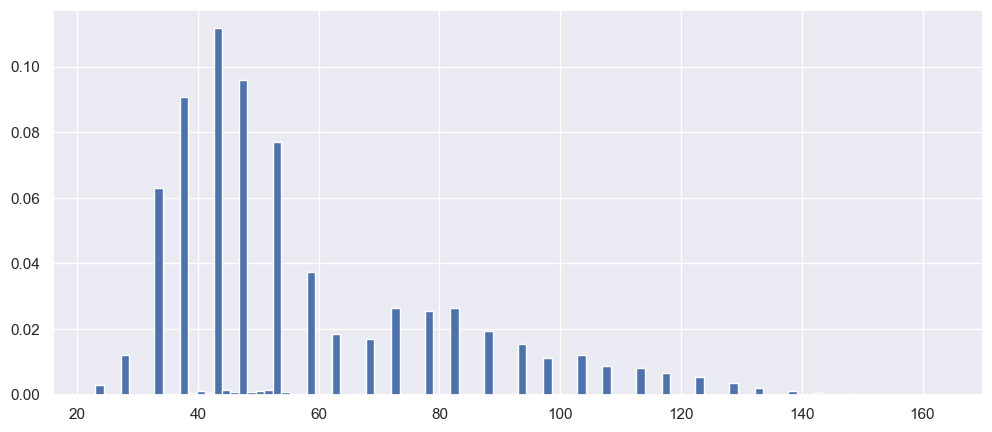

In [36]:
# there are only about 20 to 25 options, with very few specifics in between, maybe 1 in 20?
df_spec.fork_length.hist(bins=100, density=True, figsize=(12,5));

In [37]:
%%time
# simulation would be easier

counter = 0
iterations = 10000  # takes 40s to do 10k iterations, 100k lead to ~ the same number 0.08761 (at 6 min)
for i in range(iterations):
    if df_spec['fork_length'].dropna().sample().values[0] == df_spec['fork_length'].dropna().sample().values[0]:
        counter += 1
        
counter / iterations

Wall time: 38.3 s


0.084

In [38]:
%%time
# let's check between hist and spec
# less matches - is this because hist is more specific (biological detailing)

counter = 0
iterations = 20000
for i in range(iterations):
    if df_hist['fork_length'].dropna().sample().values[0] == df_spec['fork_length'].dropna().sample().values[0]:
        counter += 1
        
counter / iterations

Wall time: 54.2 s


0.01405

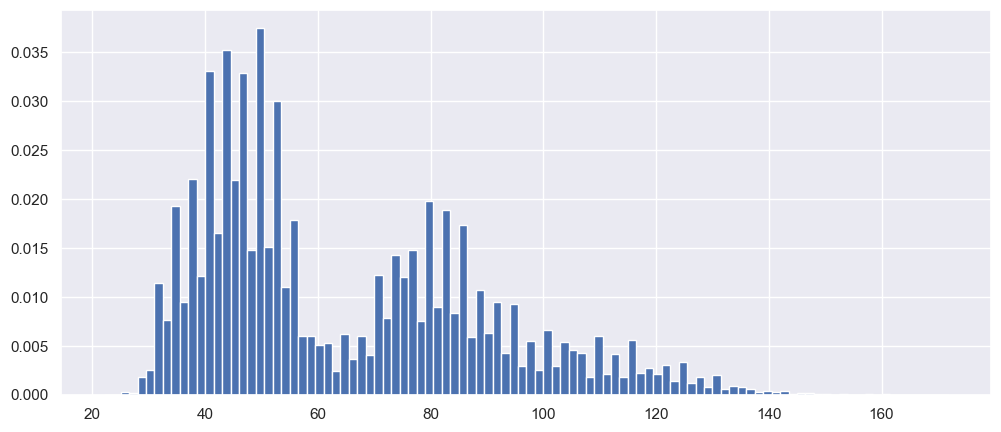

In [39]:
df_hist.fork_length.hist(bins=100, density=True, figsize=(12,5));

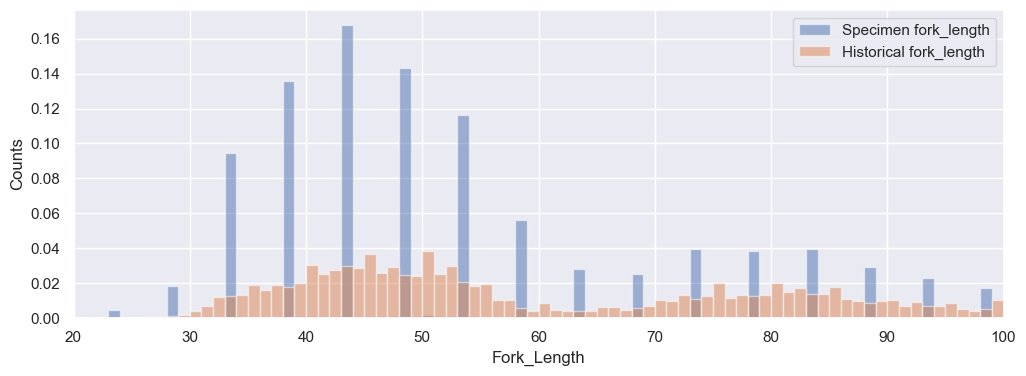

In [40]:
plt.figure(figsize=(12,4))

feature = 'fork_length'
xmin, xmax = 20, 100
bins = xmax - xmin - 1
density = True

plt.xlim(xmin, xmax)
bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 

df_spec[feature].dropna().hist(alpha=0.5, color=sns.color_palette()[0], density=density, label=f'Specimen {feature}', bins=bins_plot)
df_hist[feature].dropna().hist(alpha=0.5, color=sns.color_palette()[1], density=density, label=f'Historical {feature}', bins=bins_plot)

plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel(f'{feature.title()}')
plt.show()

# wow. that is pretty significant. can we use this to verify anything? the numbers aren't different, they're just more specific
# it also looks like our uncertainty for fork_length is +/- 2 or 3
# can't determine any way to use this info to qualify double counting or not...

In [41]:
df_spec.value_counts('fork_length').sort_values(ascending=False).head(10)

fork_length
43    11641
48     9914
38     9398
53     8040
33     6547
58     3874
73     2733
83     2722
78     2649
88     2040
dtype: int64

In [42]:
df_hist.value_counts('fork_length').sort_values(ascending=False).head(10)

fork_length
50    954
45    903
40    747
43    741
52    735
47    717
44    709
42    680
46    640
51    624
dtype: int64

# any outliers where max hist is greater than spec (matching not possible)?

In [43]:
summary = pd.merge(
    df_spec[['sample_id', 'fork_length', 'weight', 'river_age', 'sex_id']].groupby('sample_id').agg(['count', 'max', 'min']),
    df_hist[['sample_id', 'fork_length', 'weight', 'river_age', 'sex_id']].groupby('sample_id').agg(['count', 'max', 'min']),
    on='sample_id'
).rename({'fork_length_x':'fork_length_spec', 'fork_length_y':'fork_length_hist'}, axis=1)
summary.shape

(775, 24)

In [44]:
# biological samples outside of measurement tolerance
measurement_tolerance = 5
summary[
    ((summary.fork_length_spec[['max']] < summary.fork_length_hist[['max']] - measurement_tolerance)['max'])  # max hist too big
    | ((summary.fork_length_spec[['min']] > summary.fork_length_hist[['min']] + measurement_tolerance)['min'])  # min hist too small
][['fork_length_spec', 'fork_length_hist']].shape[0], summary.shape[0]

(50, 775)

# Matching Summary Plot Function

In [45]:
def plot_matching_feature_by_sample(df_specimen, df_historical, sample_id, feature, bin_width=5, density=False, subtitle=''):
    """ fixed bins is an int number of bins, if blank/False, bins are calculated by bin_width """
    
    xmin = min(df_historical.loc[df_historical.sample_id==sample_id, feature].dropna().min(), df_specimen.loc[df_specimen.sample_id==sample_id, feature].dropna().min())
    xmax = max(df_historical.loc[df_historical.sample_id==sample_id, feature].dropna().max(),df_specimen.loc[df_specimen.sample_id==sample_id, feature].dropna().max())
    xmax = xmax if xmax > xmin else xmin + bin_width  # error handling
    
    figsize=(12,4)
    xmin, xmax = round(np.trunc(xmin/bin_width)*bin_width), round(np.ceil(xmax/bin_width)*bin_width)
    
    bins = int((xmax - xmin) // bin_width - 1)
    bins = bins if bins > 0 else 1  # error handling
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)]
        
    plt.figure(figsize=figsize)
    plt.xlim(xmin, xmax)
    df_specimen.loc[df_specimen.sample_id==sample_id, feature].dropna().hist(alpha=0.5, color=sns.color_palette()[0], density=density, label=f'Specimen {feature}', bins=bins_plot)
    df_historical.loc[df_historical.sample_id==sample_id, feature].dropna().hist(alpha=0.5, color=sns.color_palette()[1], density=density, label=f'Historical {feature}', bins=bins_plot)
    
    feature_title = feature.title().replace("_"," ")
    plt.legend(loc='upper right')
    subtitle = ' - ' + subtitle if subtitle else ''
    plt.title(f'Sample {sample_id}: {feature_title} Comparison - Specimen vs Historical Data{subtitle}')
    plt.ylabel('Counts')
    plt.xlabel(f'{feature_title}')
    plt.show()


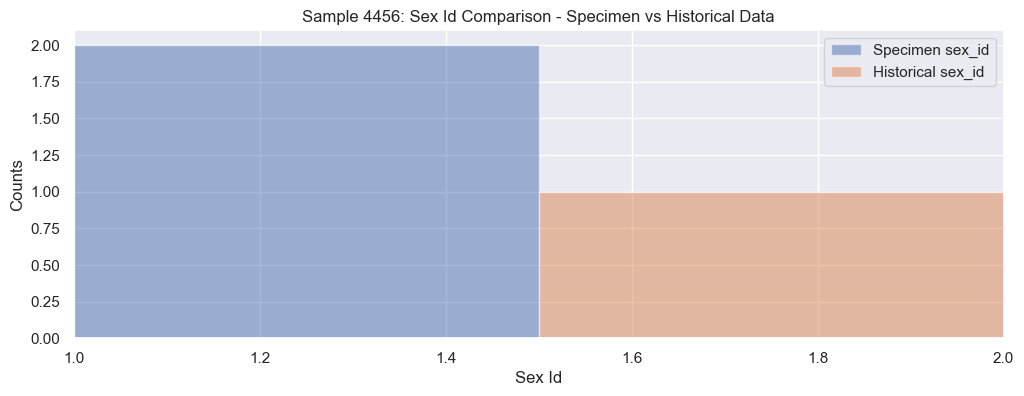

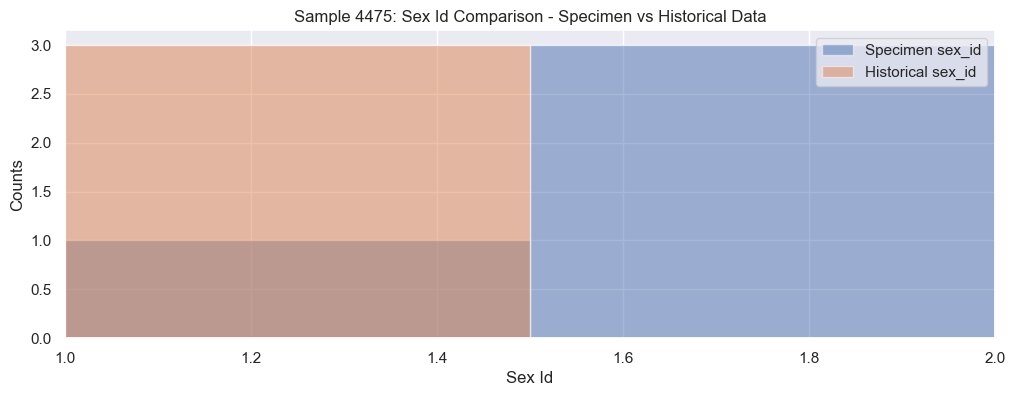

In [46]:
# sex comparison doesn't look very useful for matching
# missing values may be imputed if matching succeeds though

i_with_sex = [x for x in list(df_hist[df_hist.sex_id.notnull()].sample_id.unique()) if x in list(df_spec[df_spec.sex_id.notnull()].sample_id.unique())]

for i in i_with_sex:
    plot_matching_feature_by_sample(df_spec, df_hist, i, 'sex_id', 1)

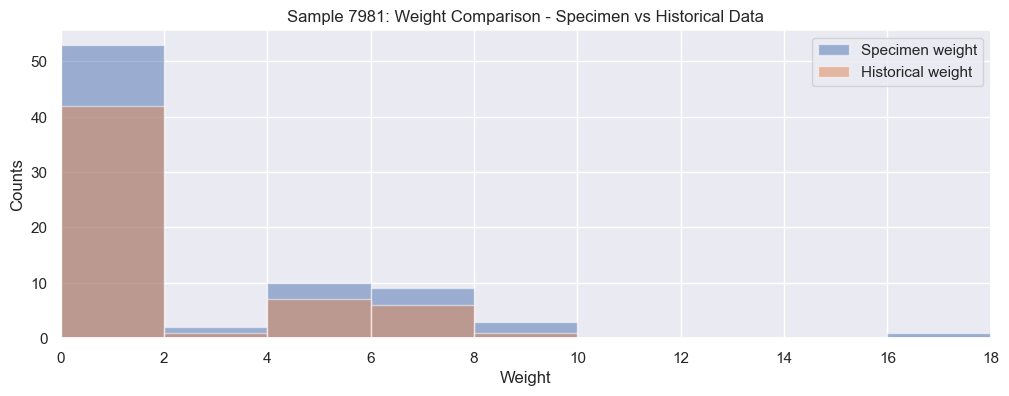

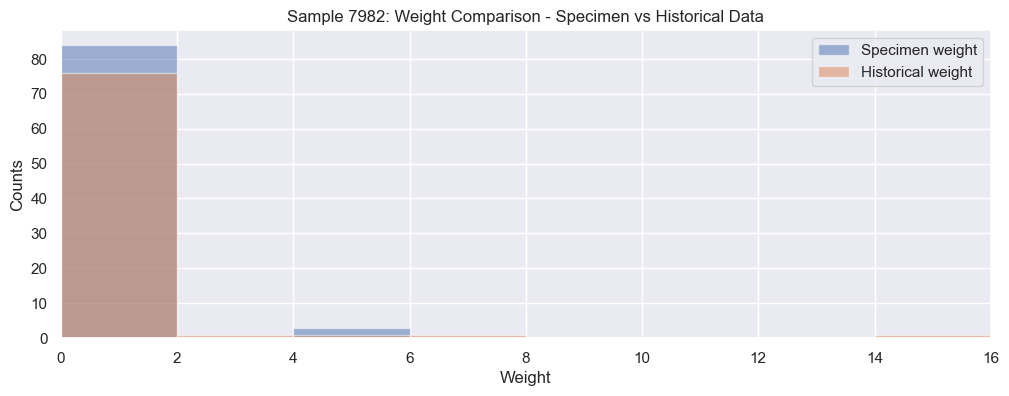

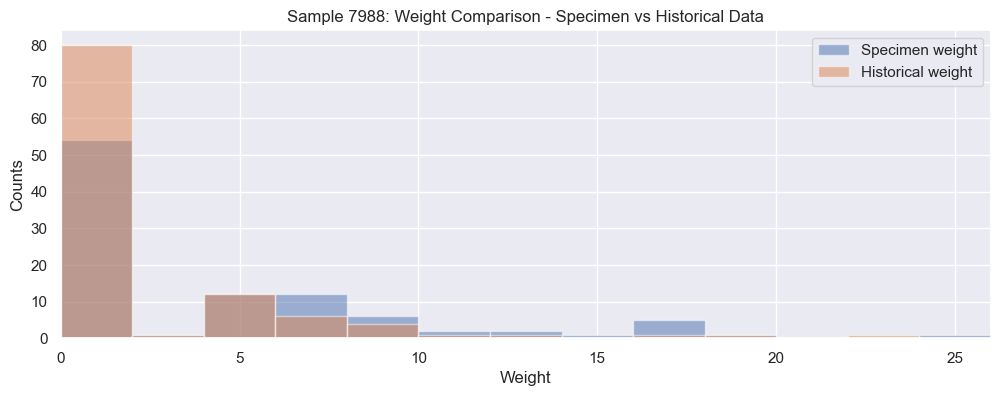

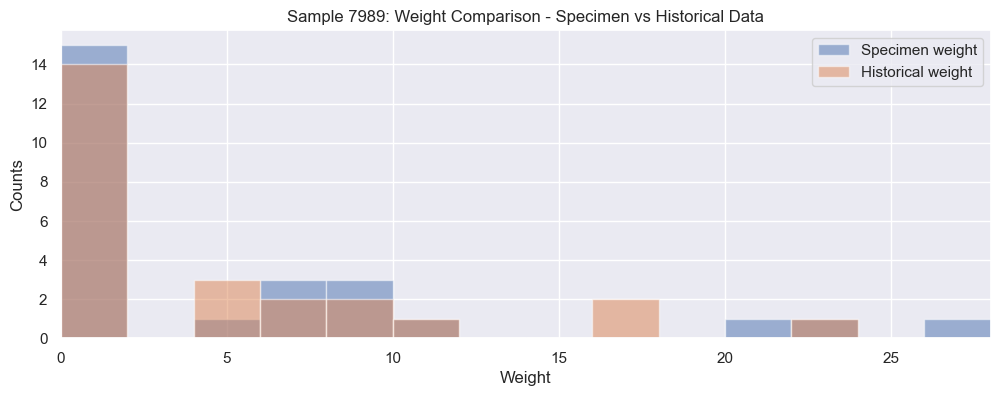

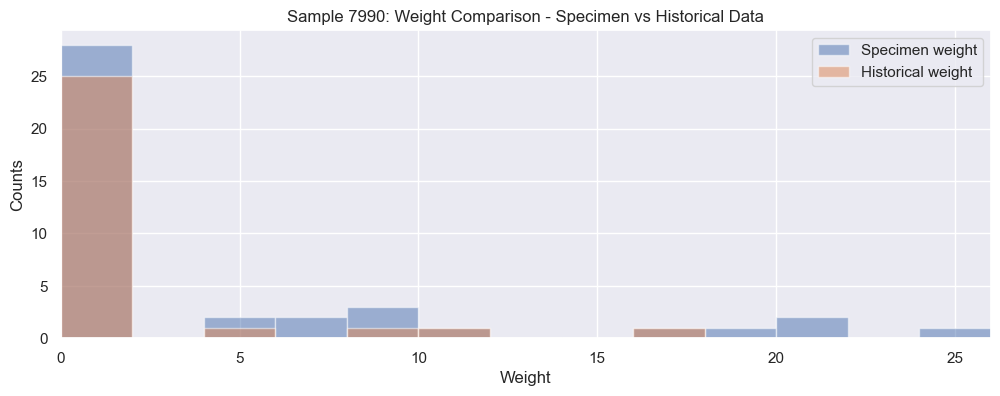

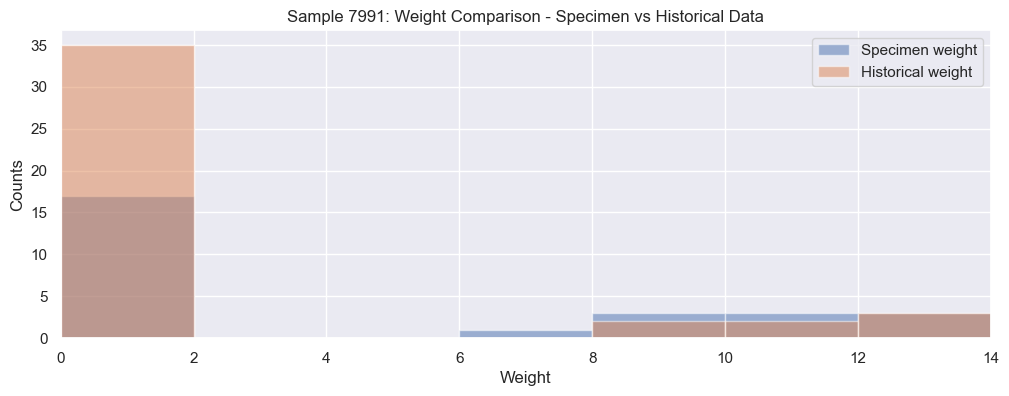

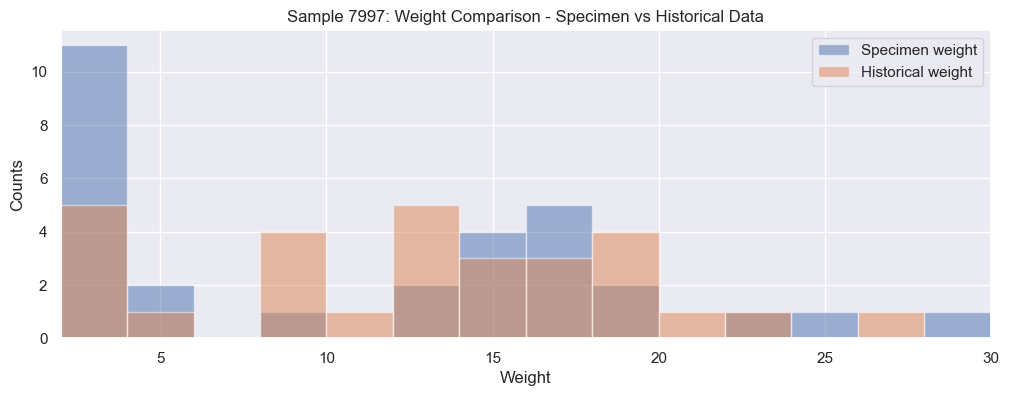

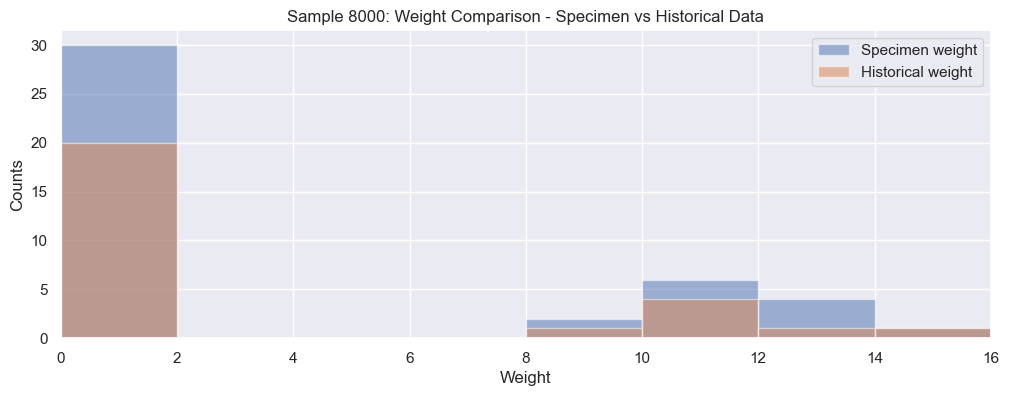

In [47]:
# weight comparison doesn't look very useful for matching
# missing values may be imputed if matching succeeds though

i_with_weight = [x for x in list(df_hist[df_hist.weight.notnull()].sample_id.unique()) if x in list(df_spec[df_spec.weight.notnull()].sample_id.unique())]

for i in i_with_weight:
    plot_matching_feature_by_sample(df_spec, df_hist, i, 'weight', 2)

# all samples - fork length comparative histograms

In [48]:
i_with_length = [x for x in list(df_hist[df_hist.fork_length.notnull()].sample_id.unique()) if x in list(df_spec[df_spec.fork_length.notnull()].sample_id.unique())]
len(i_with_length), len(list(summary.index))

(774, 775)

In [49]:
if plot_all_histograms := False:  # maybe there are too many plots to be very useful
    i_with_length = [x for x in list(df_hist[df_hist.fork_length.notnull()].sample_id.unique()) if x in list(df_spec[df_spec.fork_length.notnull()].sample_id.unique())]

    for i in i_with_length:
        plot_matching_feature_by_sample(df_spec, df_hist, i, 'fork_length')

# HIST COUNTS vs SPEC COUNTS

In [50]:
type_counts = pd.merge(
    df_hist.groupby('sample_id').count().reset_index()[['sample_id', 'id']].rename({'id':'hist_count'}, axis=1), 
    df_spec.groupby('sample_id').count().reset_index()[['sample_id', 'id']].rename({'id':'spec_count'}, axis=1),
    on='sample_id', 
    how='left'
)
type_counts.spec_count = type_counts.spec_count.astype('Int64')

# SPEC COUNT == HIST COUNT
## likely double counts

In [51]:
# there are a lot of exact matches
type_counts[type_counts.hist_count == type_counts.spec_count].shape[0]

179

In [52]:
if plot_all_exact_matches := False:
    for i in list(type_counts[type_counts.hist_count == type_counts.spec_count].sample_id):
        plot_matching_feature_by_sample(df_spec, df_hist, i, 'fork_length', 2, subtitle='Exactly Matched Fish Counts')

# if we match fish 1 to 1, how much error do we get?

In [53]:
"""NOTE: this is not the best way to line up samples that don't have matching numbers of samples"""

def matching_error_summary(sample_id, feature='fork_length'):
    df = pd.concat([
        (
            df_spec
            .loc[df_spec.sample_id==sample_id, ['sample_id', 'id', feature]]
            .sort_values(feature)
            .rename({'id':'spec_id',f'{feature}':f'{feature}_spec'}, axis=1)
            .reset_index(drop=True)
        ),
        (
            df_hist
            .loc[df_hist.sample_id==sample_id, ['id', feature]]
            .sort_values(feature)
            .rename({'id':'hist_id',f'{feature}':f'{feature}_hist'}, axis=1)
            .reset_index(drop=True)
        )
    ], axis=1)[['sample_id', 'spec_id', 'hist_id', f'{feature}_spec', f'{feature}_hist']]

    df['error'] = df[f'{feature}_spec'] - df[f'{feature}_hist']
    
    return df


def error_summary(df):
    """ returns a tuple of mean squared error (MSE), mean error (ME) """
    return (df.error * df.error).mean(), df.error.mean()


def error_stats(sample_id):
    return error_summary(matching_error_summary(sample_id))


error_summary(matching_error_summary(7839))

(1.4, 0.0)

In [54]:
summary[['length_MSE', 'length_ME']] = pd.NA

for i, _ in summary.iterrows():
    summary.loc[i, ['length_MSE', 'length_ME']] = error_stats(i)
    
summary.length_MSE, summary.length_ME = summary.length_MSE.fillna(0).astype(float), summary.length_ME.fillna(0).astype(float)

In [55]:
summary[(summary.fork_length_spec['count']>0)&(summary.fork_length_hist['count']>0)].sort_values('length_MSE').head(20)

fork_length_spec           weight_x         river_age_x              \
                     count  max  min    count max min       count   max   min   
sample_id                                                                       
7611                     1  138  138        0 NaN NaN           1 2.000 2.000   
7948                     2  138  138        0 NaN NaN           2 2.000 2.000   
4635                     5  143  128        0 NaN NaN           5 2.000 2.000   
7187                     7   98   78        0 NaN NaN           7 1.000 1.000   
4579                     1   73   73        0 NaN NaN           1 0.000 0.000   
7612                     2  108   78        0 NaN NaN           2 2.000 1.000   
7767                     1   88   88        0 NaN NaN           1 1.000 1.000   
4634                     2  118   28        0 NaN NaN           2 2.000 0.000   
7680                     9  128   88        0 NaN NaN           9 2.000 1.000   
7766                     2   48   48        0 NaN NaN           2 0.000 0.000   
7691                     1  103  103        0 NaN NaN           1 2.000 2.000   
7639                     1   73   73        0 NaN NaN           1 1.000 1.000   
7609                    95   93   28        0 NaN NaN          95 2.000 0.000   
7598                    41   73   28        0 NaN NaN          41 1.000 0.000   
7168                     9  138   88        0 NaN NaN           9 2.000 1.000   
7785                    35  123   38        0 NaN NaN          35 2.000 0.000   
7589                     5  128   93        0 NaN NaN           5 2.000 2.000   
7839                    10  113   43        0 NaN NaN          10 2.000 0.000   
7780                    33  128   38        0 NaN NaN          33 2.000 0.000   
7760                    47  118   38        0 NaN NaN          47 2.000 0.000   

          sex_id_x             fork_length_hist           weight_y        \
             count   max   min            count  max  min    count   max   
sample_id                                                                  
7611             0  <NA>  <NA>                1  138  138        0   NaN   
7948             0  <NA>  <NA>                2  138  137        0   NaN   
4635             0  <NA>  <NA>                2  132  128        0   NaN   
7187             0  <NA>  <NA>                2   92   78        2 9.400   
4579             0  <NA>  <NA>                1   74   74        0   NaN   
7612             0  <NA>  <NA>                2  107   79        0   NaN   
7767             0  <NA>  <NA>                1   87   87        0   NaN   
4634             0  <NA>  <NA>                1   29   29        0   NaN   
7680             0  <NA>  <NA>                9  128   87        0   NaN   
7766             0  <NA>  <NA>                2   47   47        0   NaN   
7691             0  <NA>  <NA>                1  104  104        0   NaN   
7639             0  <NA>  <NA>                1   74   74        0   NaN   
7609             0  <NA>  <NA>               95   93   30        0   NaN   
7598             0  <NA>  <NA>               41   75   30        0   NaN   
7168             0  <NA>  <NA>                9  137   87        0   NaN   
7785             0  <NA>  <NA>               35  124   38        0   NaN   
7589             0  <NA>  <NA>                5  128   94        0   NaN   
7839             0  <NA>  <NA>               10  112   45        0   NaN   
7780             0  <NA>  <NA>               33  129   38        0   NaN   
7760             0  <NA>  <NA>               47  118   37        0   NaN   

                river_age_y             sex_id_y             length_MSE  \
            min       count   max   min    count   max   min              
sample_id                                                                 
7611        NaN           1 2.000 2.000        0  <NA>  <NA>      0.000   
7948        NaN           2 2.000 2.000        0  <NA>  <NA>      0.500   
4635        NaN       

In [56]:
summary[(summary.fork_length_spec['count']>0)&(summary.fork_length_hist['count']>0)].shape

(774, 26)

In [57]:
summary[['length_MSE', 'length_ME']].describe(percentiles=[0.01,.05,.1,.9,.95,.99])

,length_MSE,length_ME
,,
count,775.000,775.000
mean,824.714,-16.361
std,1241.448,18.044
min,0.000,-93.000
1%,1.000,-76.072
5%,1.815,-48.881
10%,2.105,-39.080
50%,380.379,-12.722
90%,2207.412,0.000


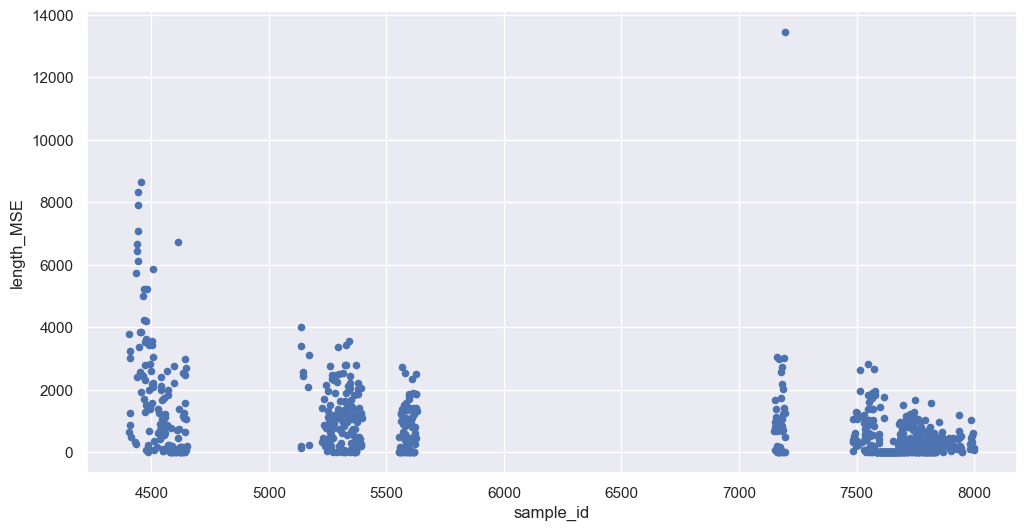

In [58]:
summary.reset_index()[['sample_id','length_MSE']].plot(x='sample_id', y='length_MSE', kind='scatter', figsize=(12,6));

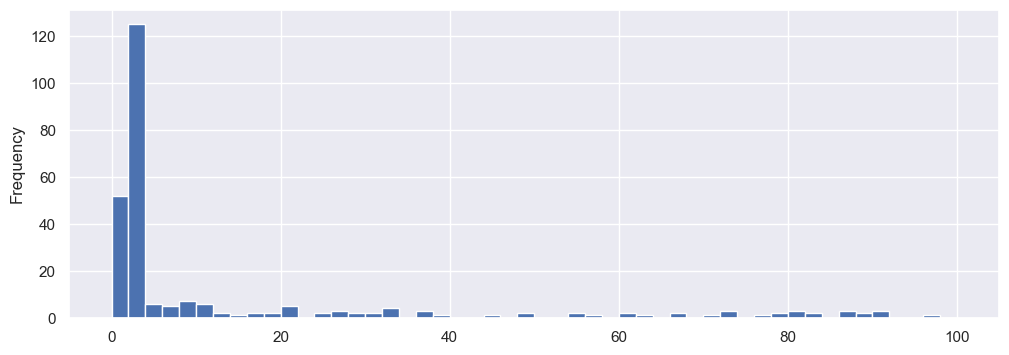

In [59]:
bin_width = 2
summary.reset_index()[['length_MSE']].plot(kind='hist', bins=[x*bin_width for x in range(100//bin_width+1)], legend=False, figsize=(12,4));

# overlap between low error and exact count matches

47 low error samples with exact count matches



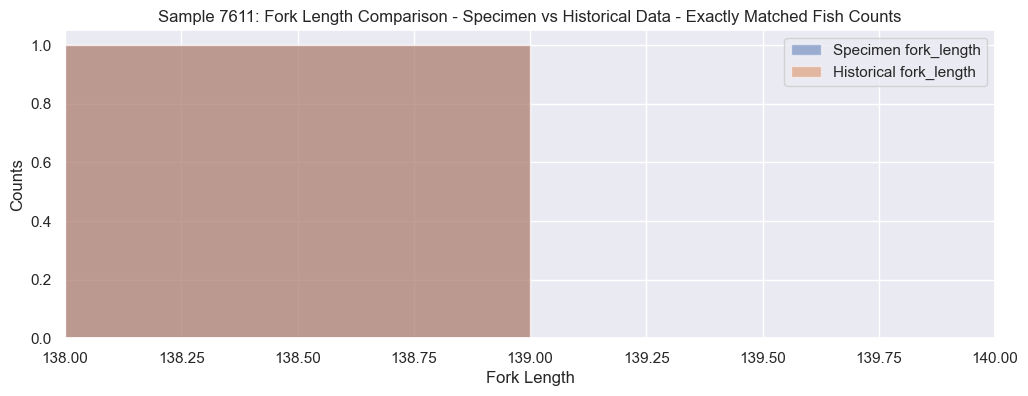

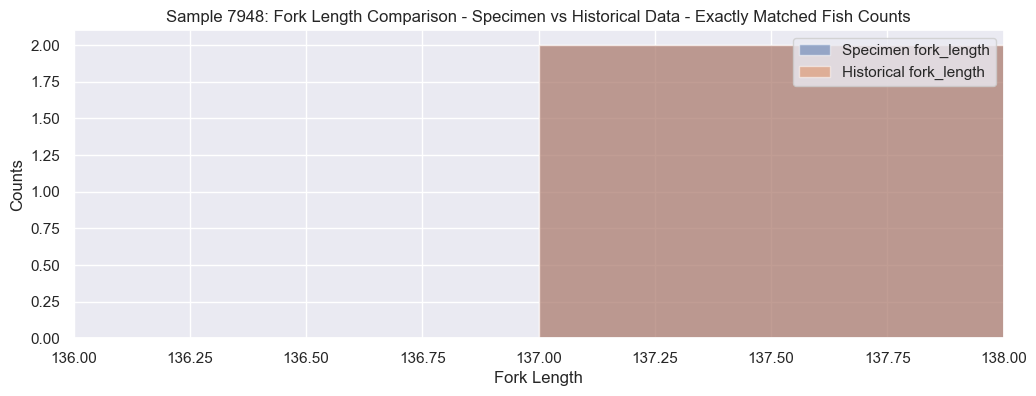

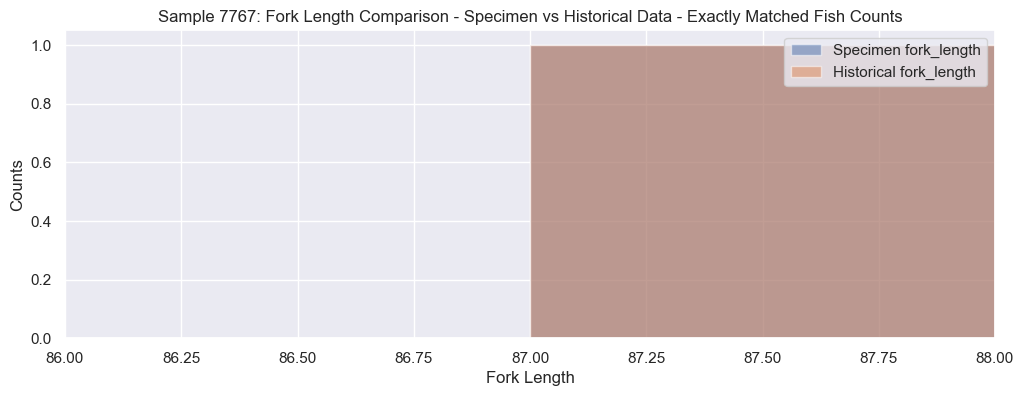

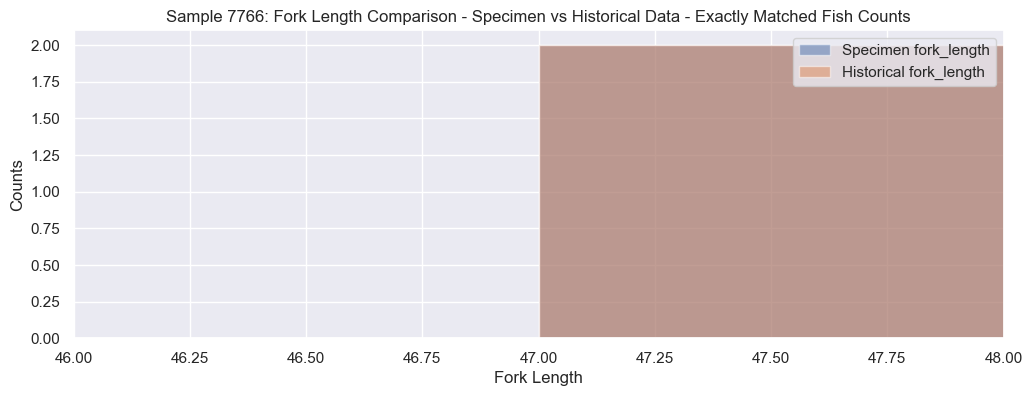

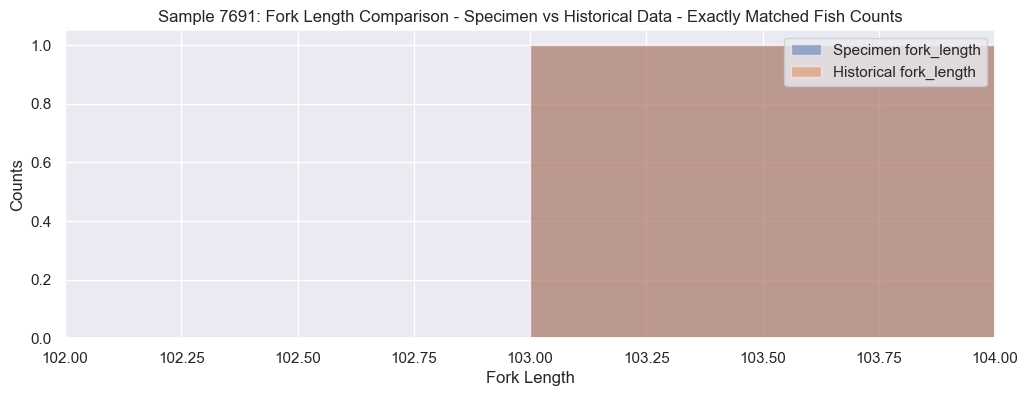

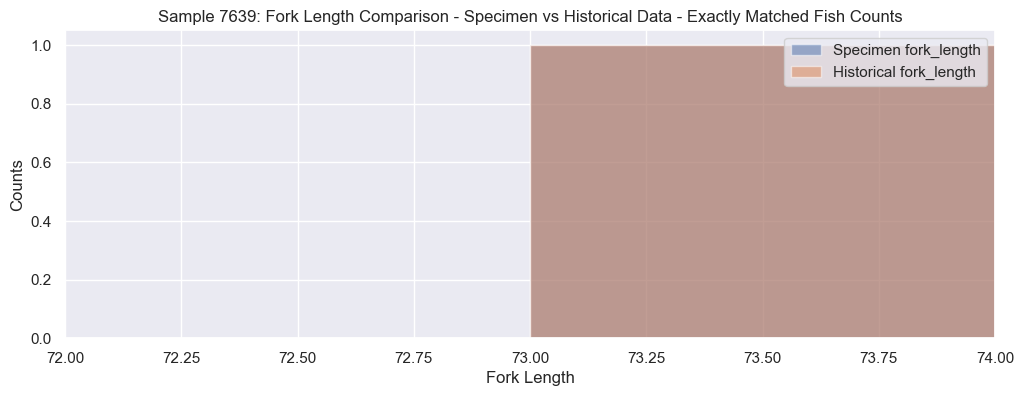

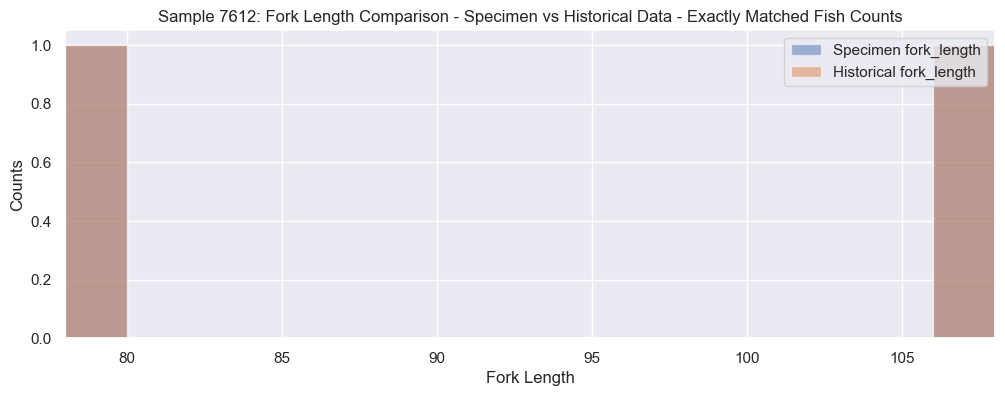

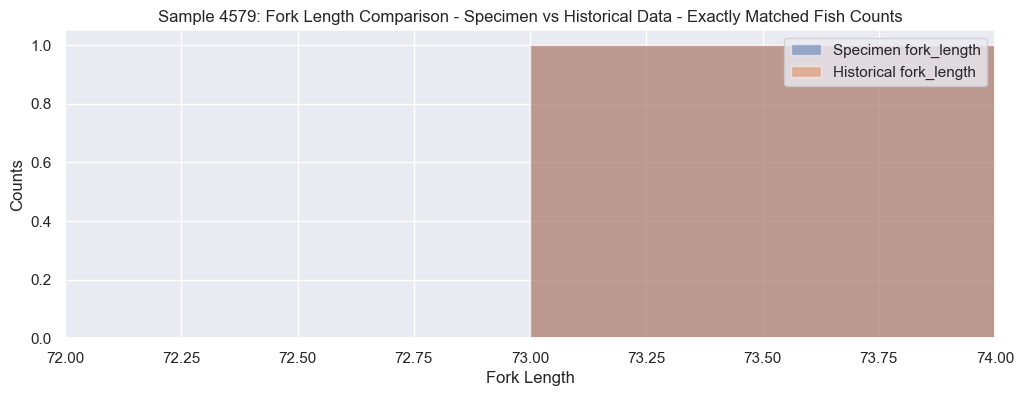

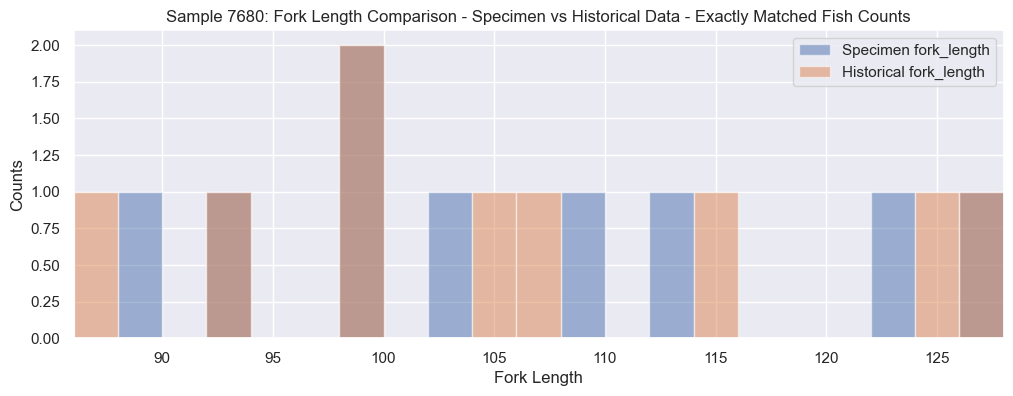

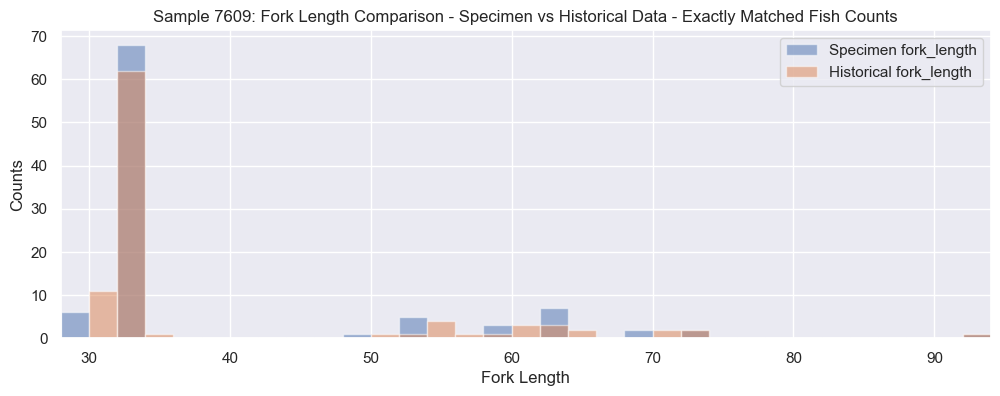

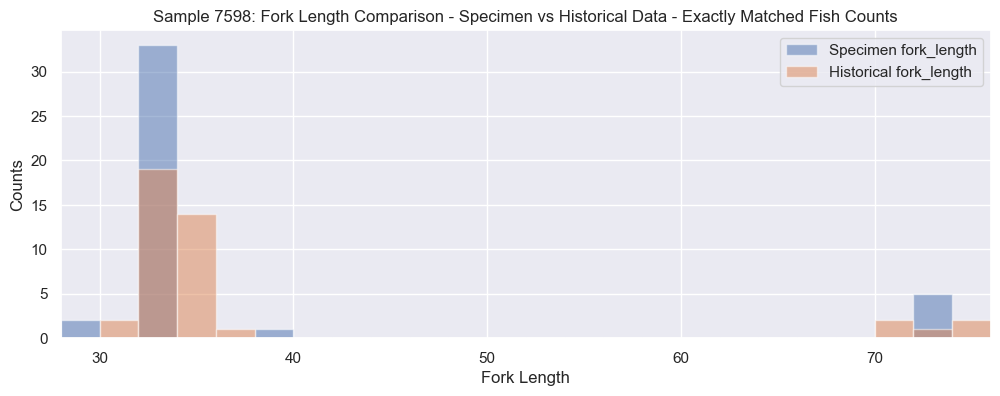

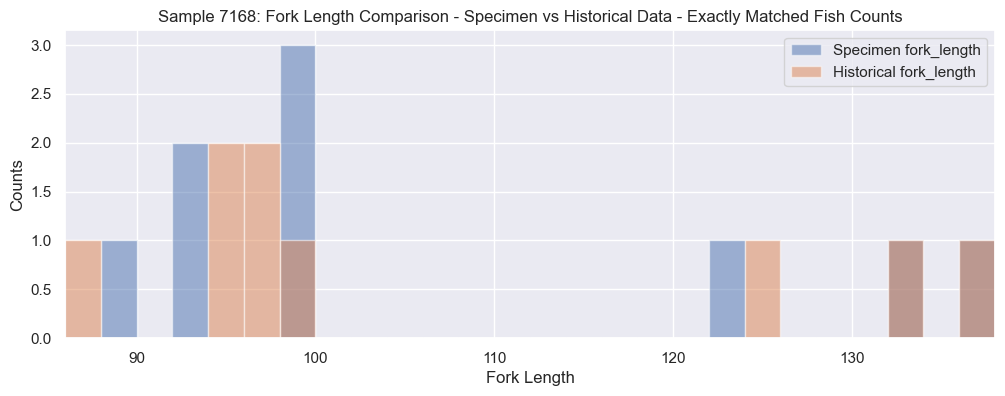

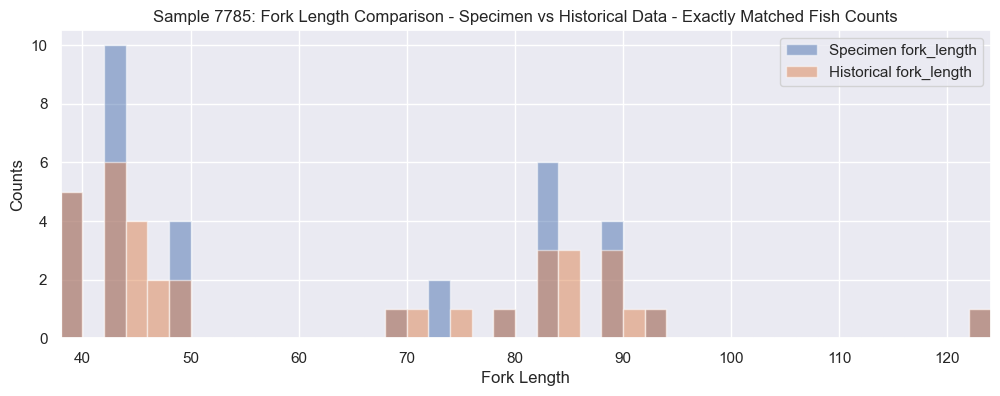

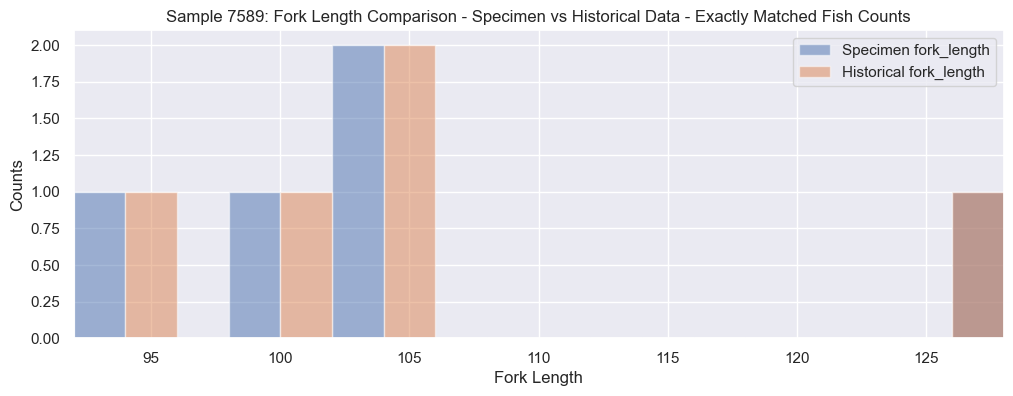

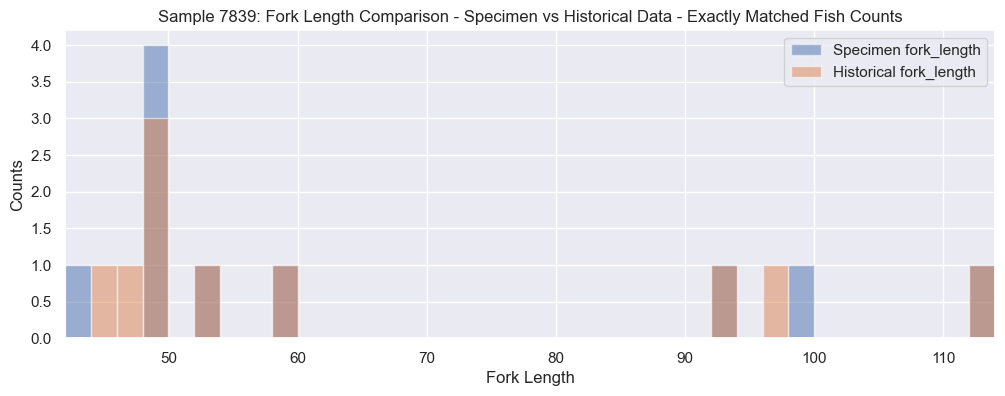

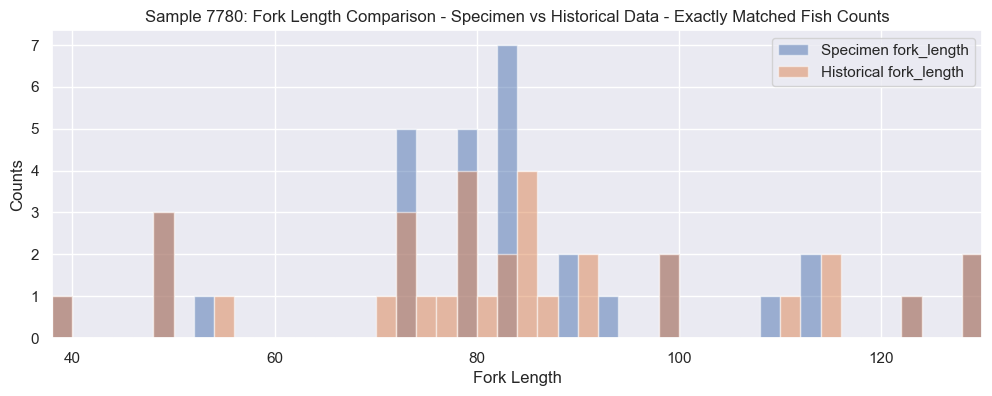

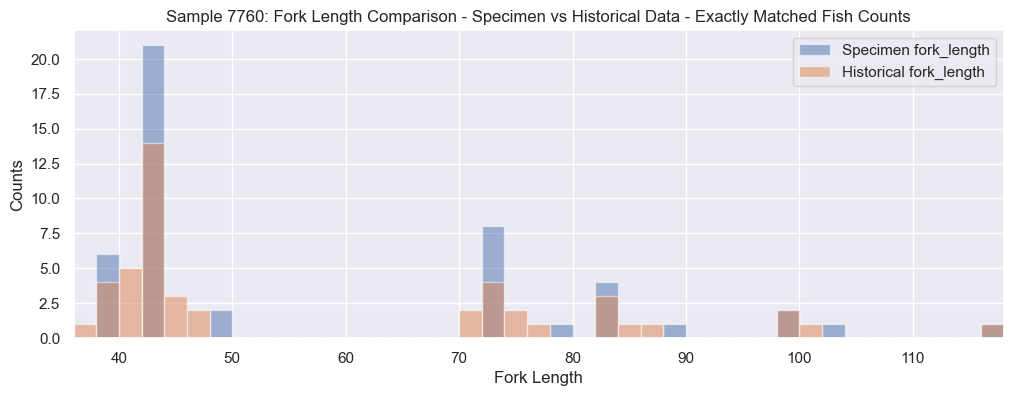

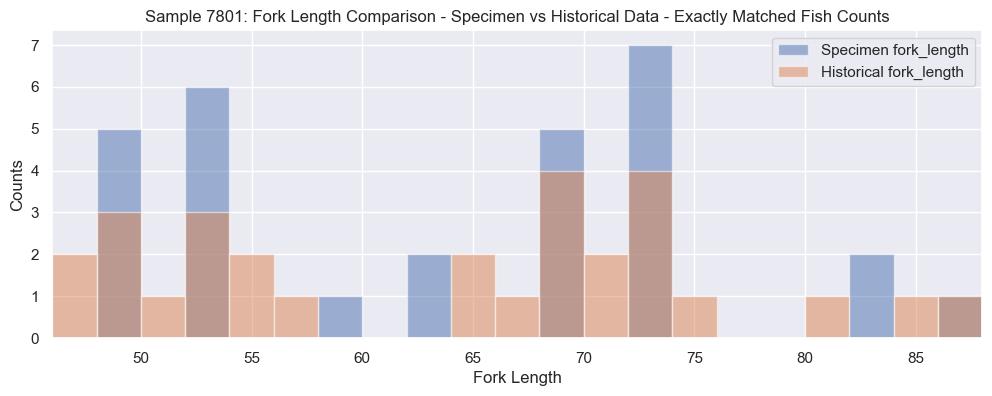

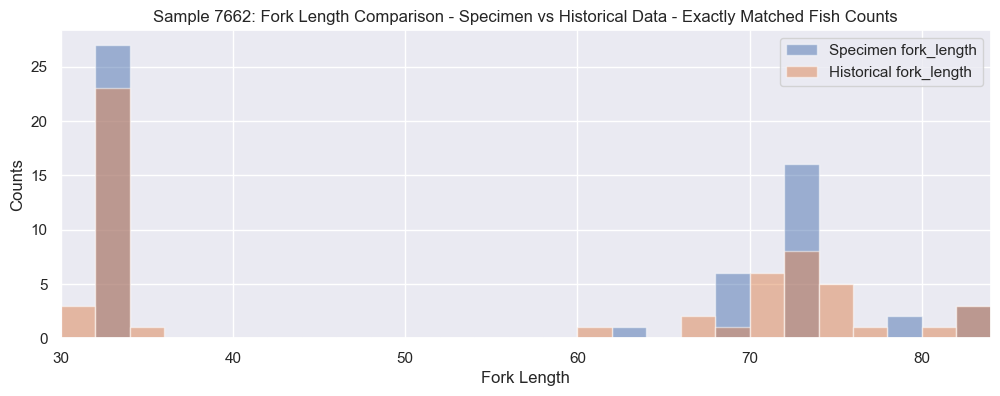

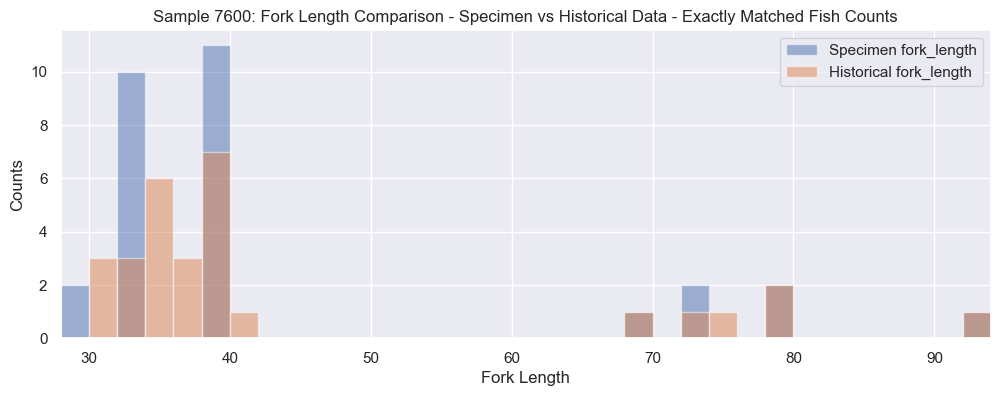

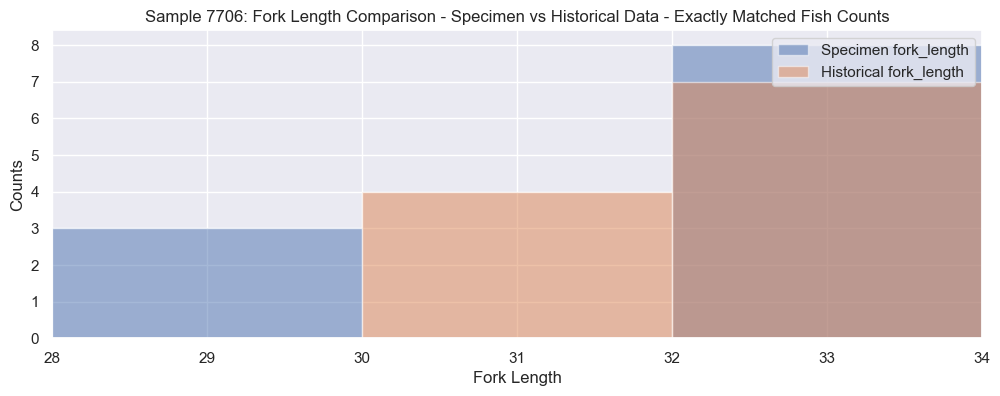

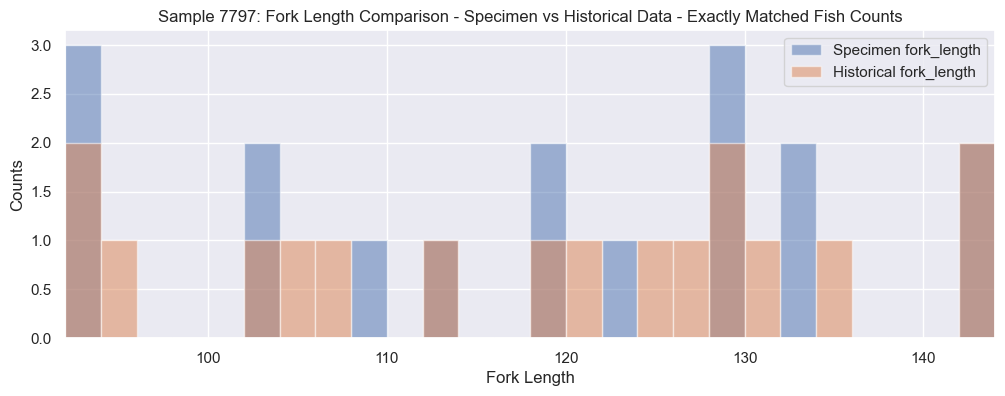

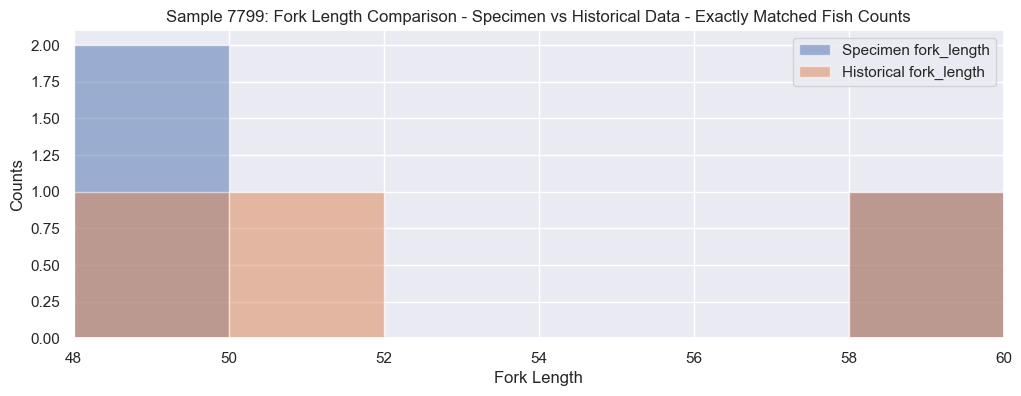

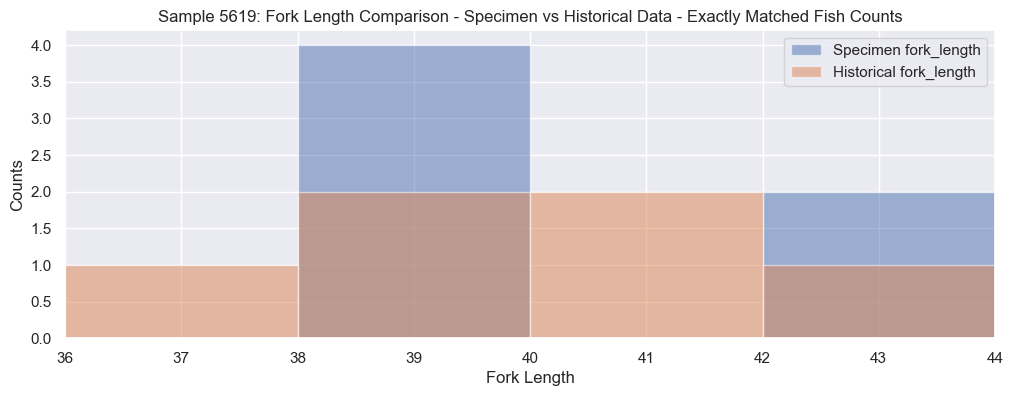

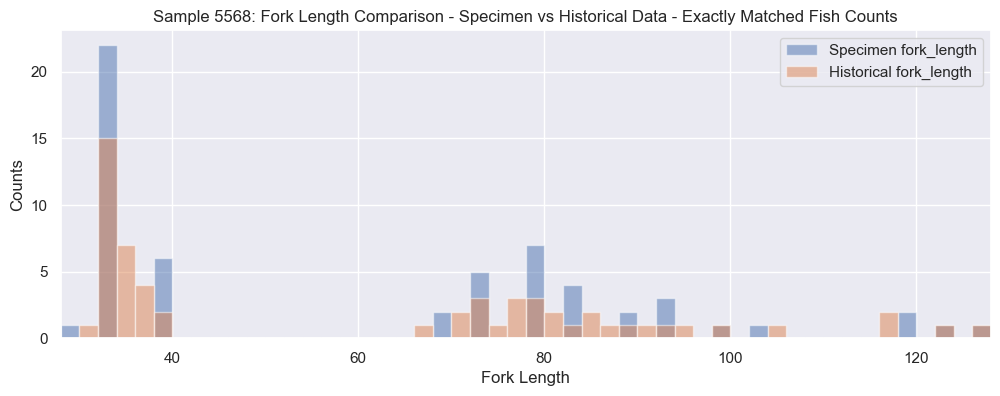

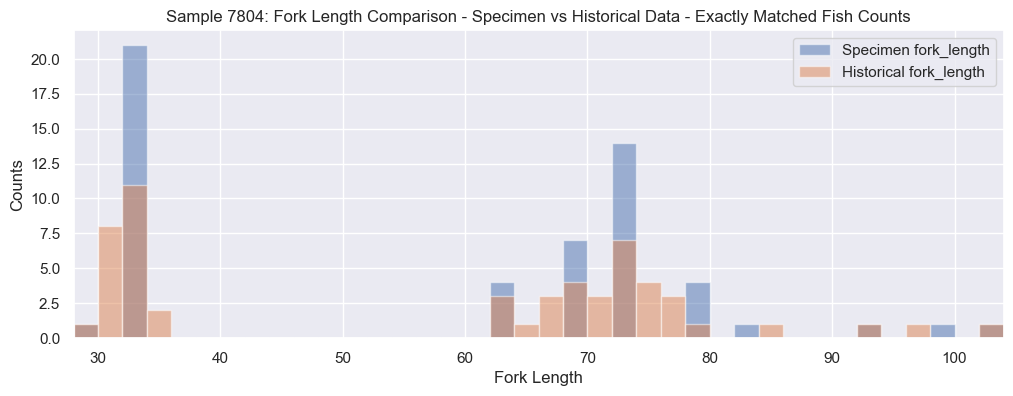

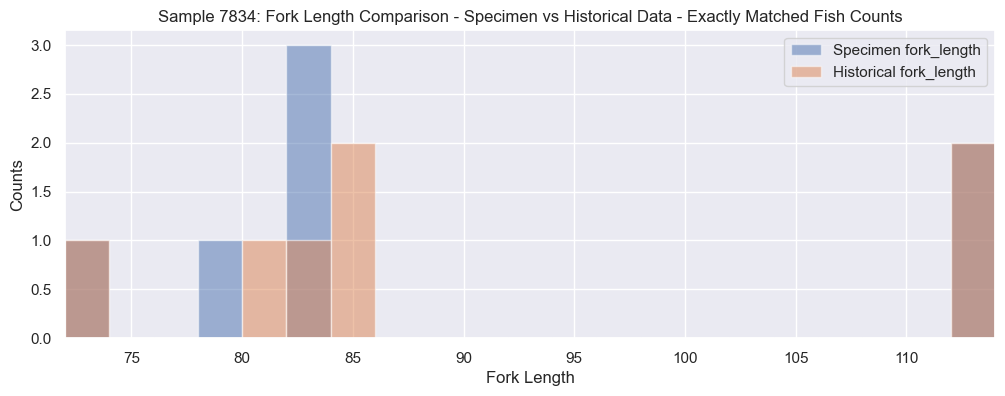

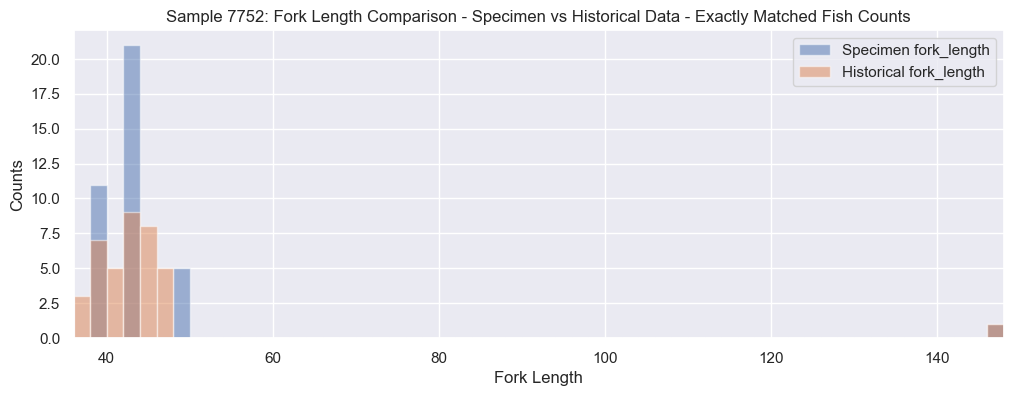

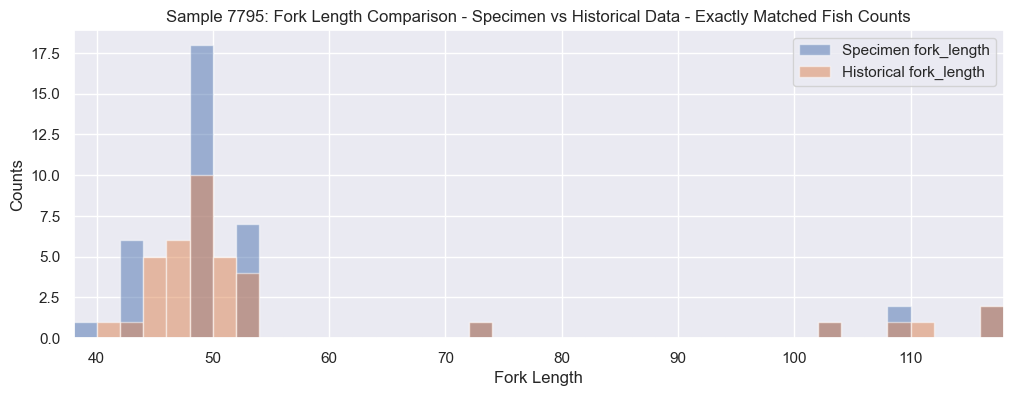

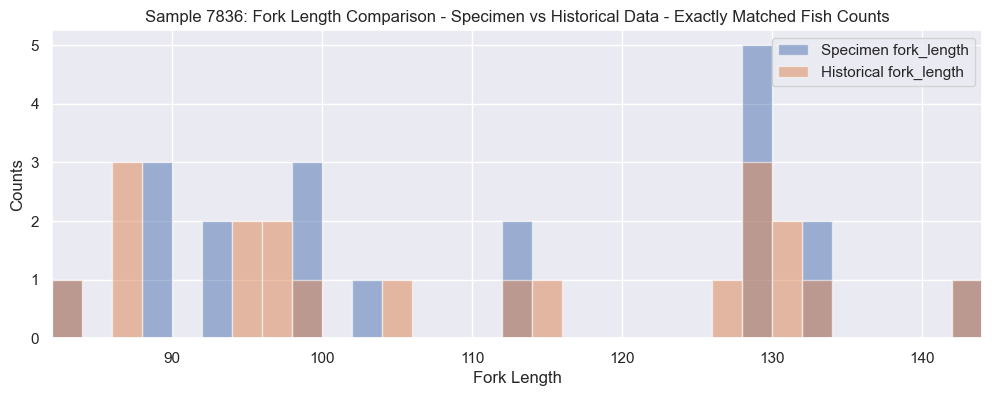

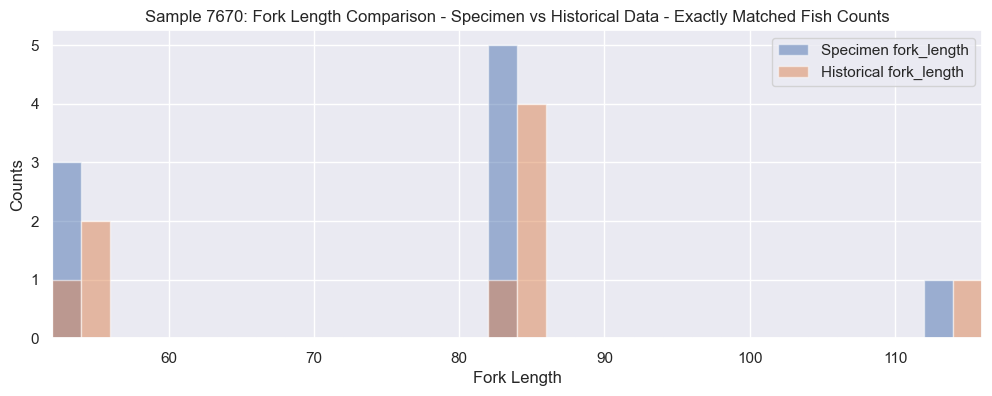

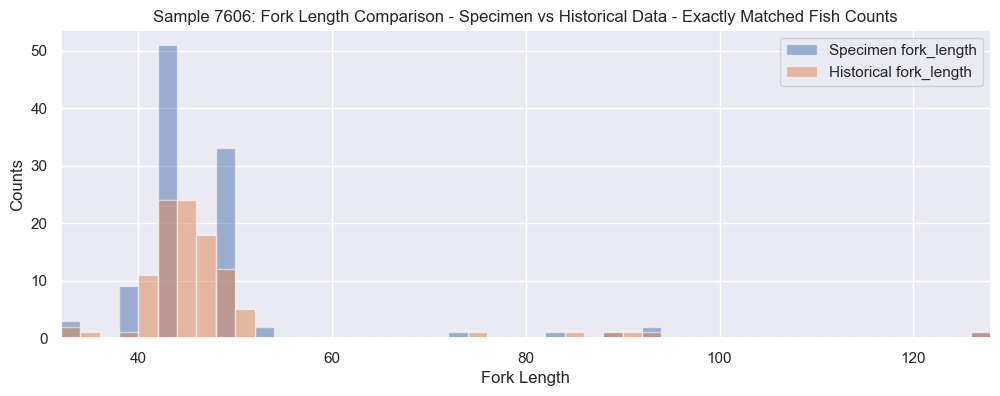

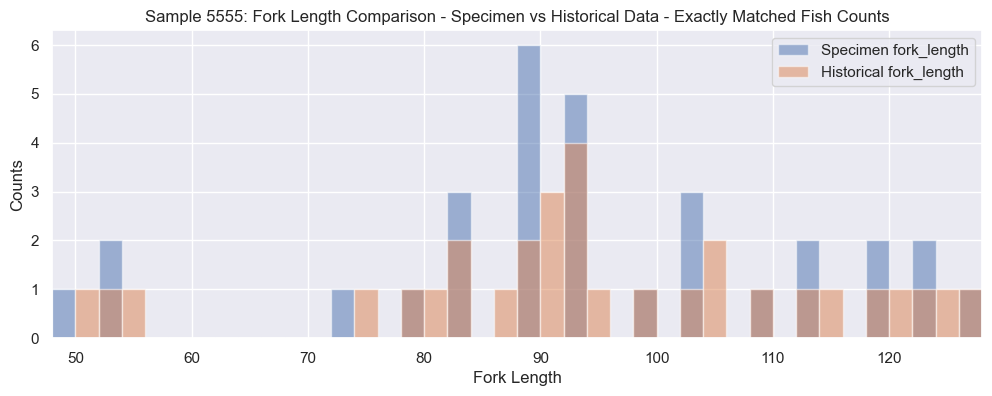

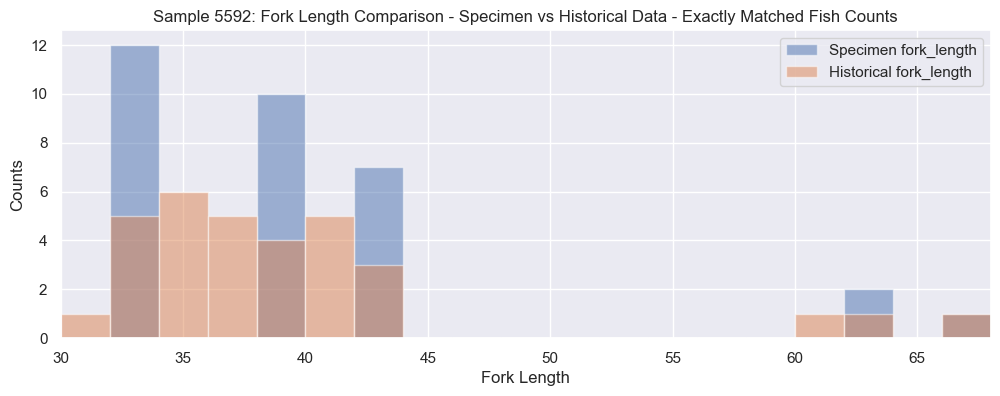

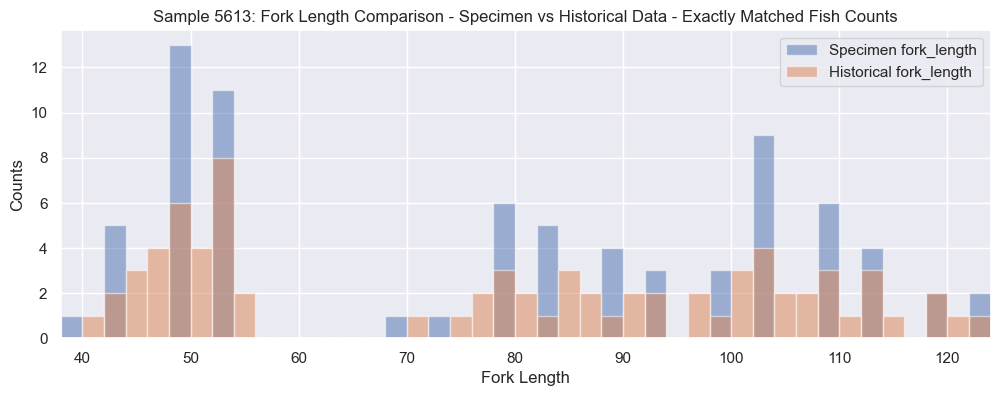

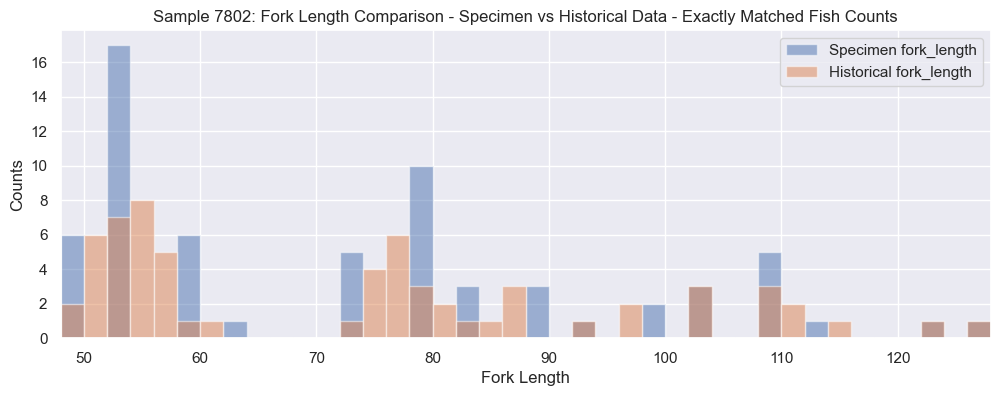

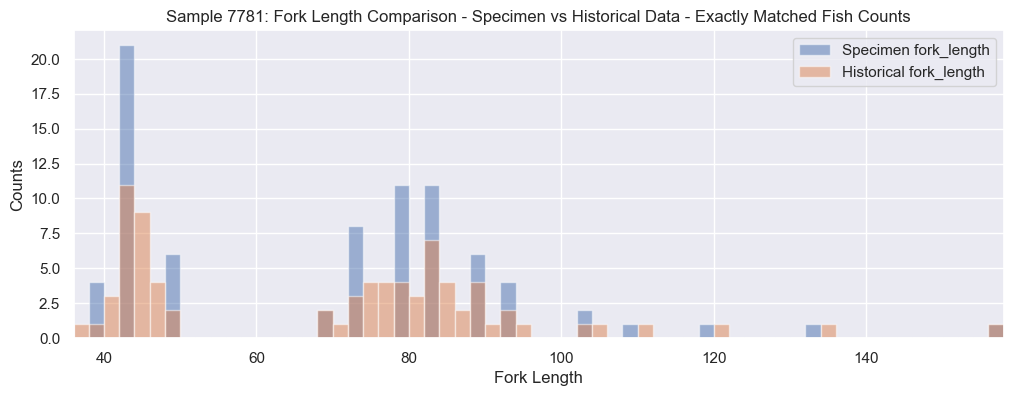

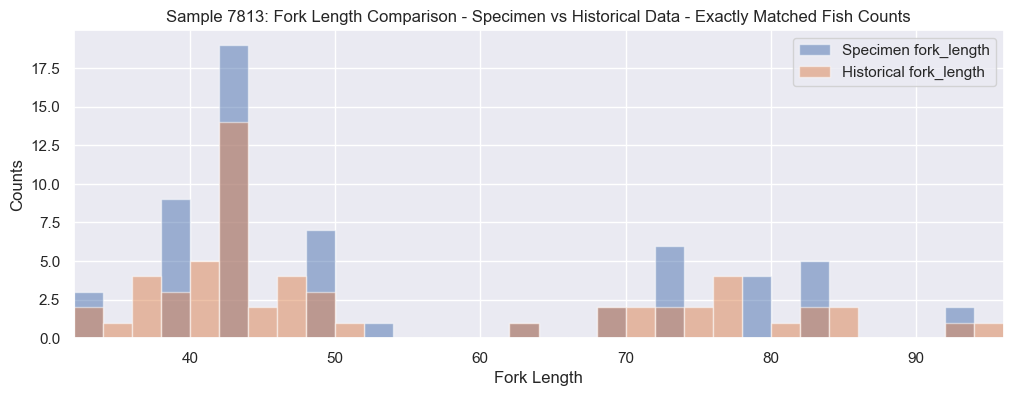

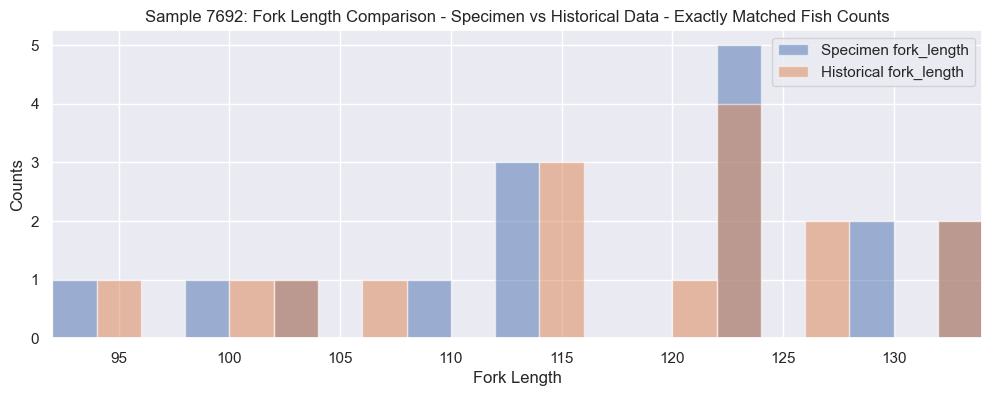

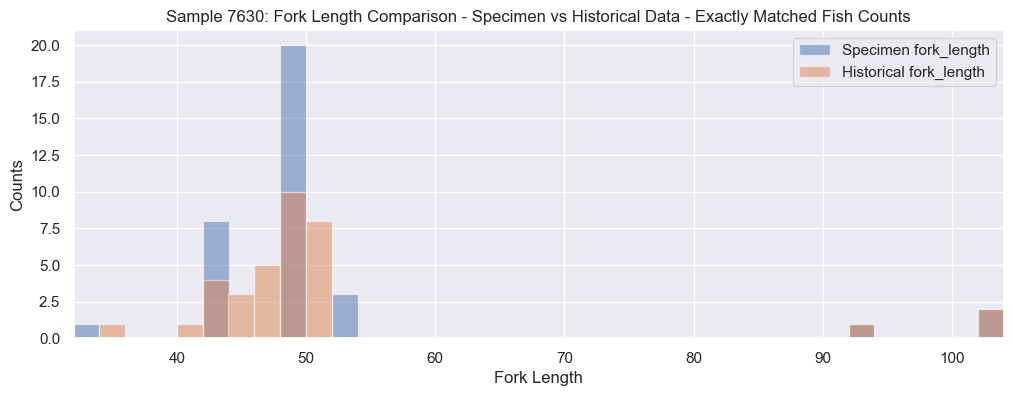

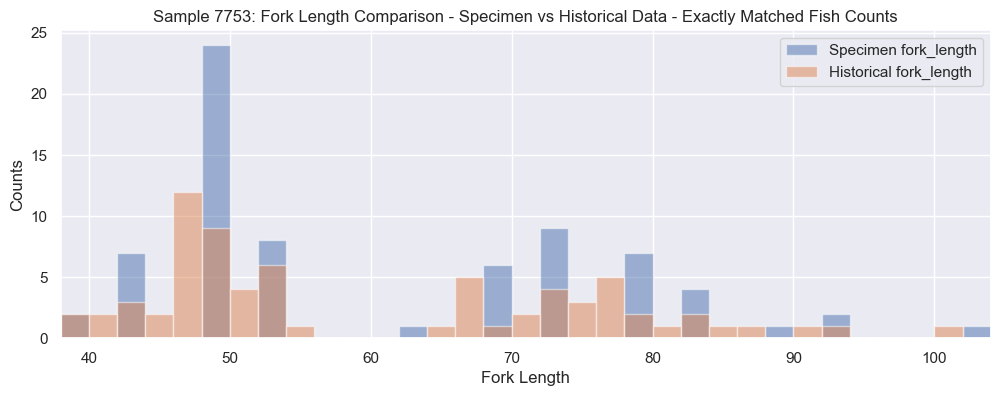

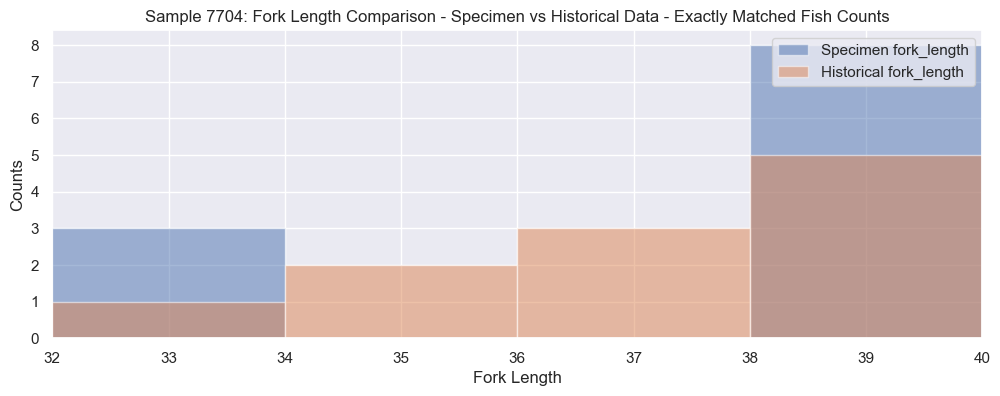

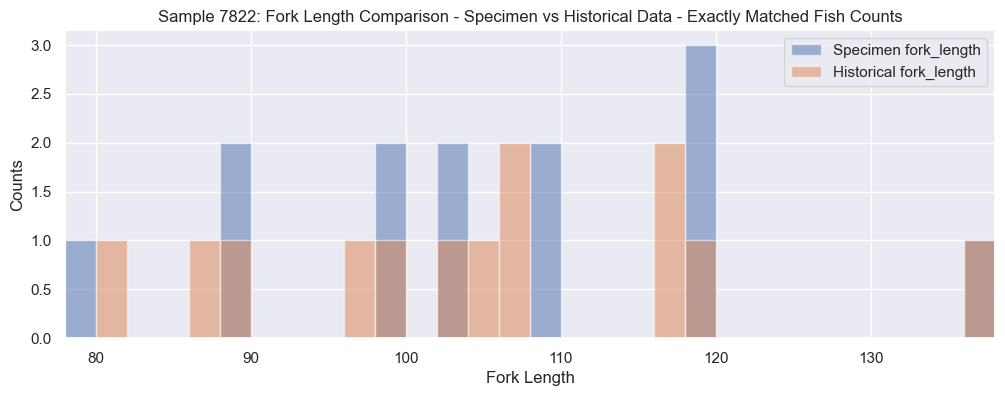

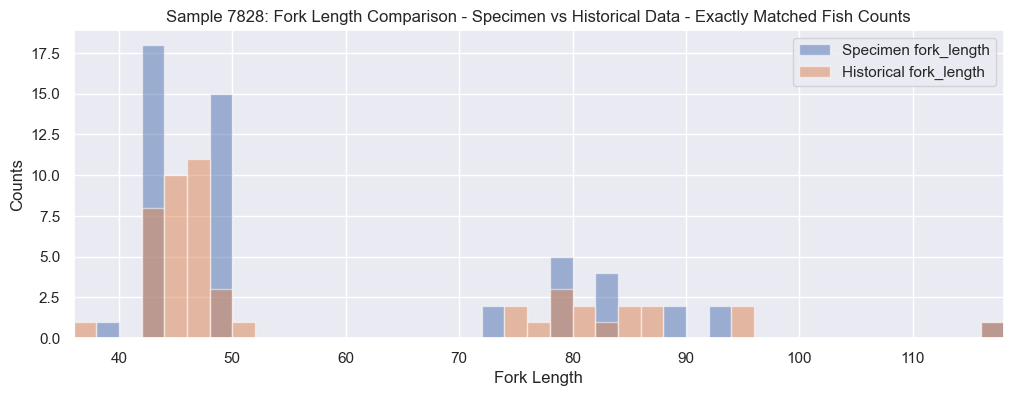

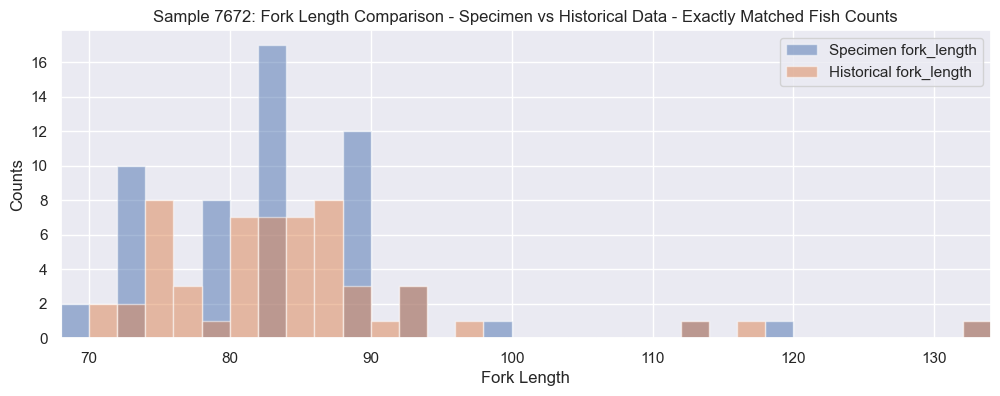

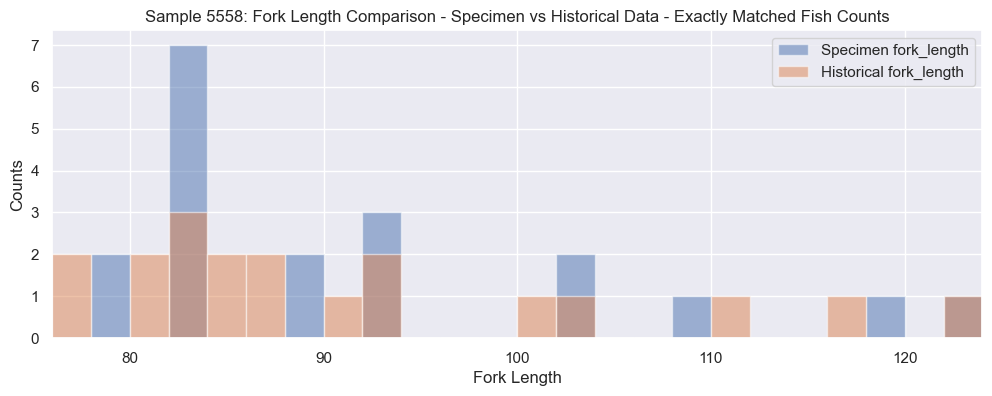

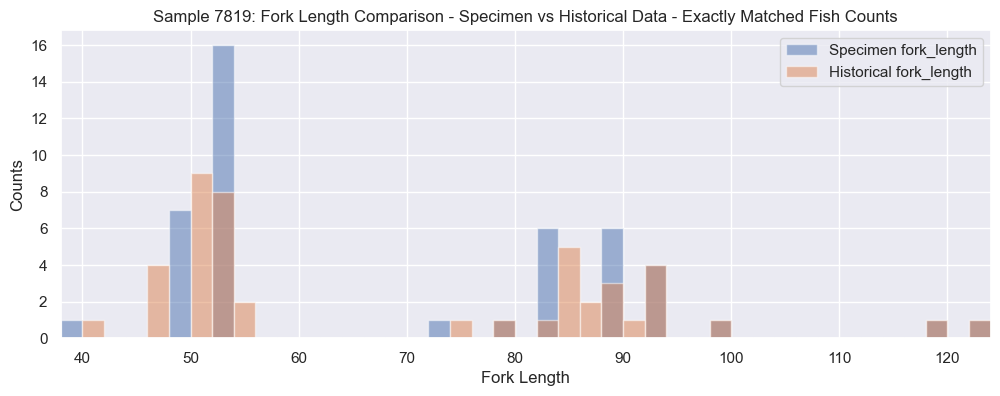

In [60]:
threshold = 2
low_error_exact_count = [x for x in list(summary[summary.length_MSE<threshold].sort_values('length_MSE').index) if x in list(type_counts[type_counts.hist_count == type_counts.spec_count].sample_id)]

print(len(low_error_exact_count), 'low error samples with exact count matches\n')

for i in low_error_exact_count:
    plot_matching_feature_by_sample(df_spec, df_hist, i, 'fork_length', bin_width=threshold, subtitle='Exactly Matched Fish Counts')


# if hist is a subset of spec
* check for matches within a threshold
* confirm no extras in hist that don't fit
* UNCERTAIN ABOUT THIS STEP: determine whether matches are exact or coincidental

* Very few samples have weight or sex for BOTH spec and hist, but should check while matching

### why this needs to be sorted

In [62]:
# confirm sample_id are in order

current_id = 0
id_count = 0
checkthis = []

for i, row in df_hist.iterrows():
    if row.sample_id != current_id:
        if row.sample_id == 4598:
            print('i found 4598')
        id_count += 1
        current_id = row.sample_id
        if current_id in checkthis:
            print(current_id)
        checkthis += [current_id]

id_count, df_hist.sample_id.nunique()

# ugg, one is wrong......

i found 4598
i found 4598
4598


(794, 793)

In [63]:
df_hist[df_hist.sample_id==4598]

,id,fork_length,total_length,weight,age_type,river_age,notes,old_id,life_stage_id,sample_id,sex_id,status_id,matching_id
931,70283,50,NaN,NaN,1.000,0.000,None,GD_7504,1,4598,<NA>,10,4598500_00
932,70284,51,NaN,NaN,1.000,0.000,None,GD_7505,1,4598,<NA>,10,4598510_00
933,70285,53,NaN,NaN,1.000,0.000,None,GD_7506,1,4598,<NA>,10,4598530_00
934,70286,54,NaN,NaN,1.000,0.000,None,GD_7507,1,4598,<NA>,10,4598540_00
935,70287,56,NaN,NaN,1.000,0.000,None,GD_7508,1,4598,<NA>,10,4598560_00
936,70288,93,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7509,1,4598,2,4,4598930_02
937,70289,95,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7510,1,4598,1,4,4598950_01
938,70290,97,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7511,1,4598,2,4,4598970_02
940,70292,131,NaN,NaN,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7513,1,4598,1,4,45981310_01
941,70293,135,NaN,NaN,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7514,1,4598,2,4,45981350_02


In [64]:
# row 939 (4599) is problematic
df_hist.loc[937:943]

,id,fork_length,total_length,weight,age_type,river_age,notes,old_id,life_stage_id,sample_id,sex_id,status_id,matching_id
937,70289,95,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7510,1,4598,1,4,4598950_01
938,70290,97,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7511,1,4598,2,4,4598970_02
939,70291,118,NaN,14.600,1.000,2.000,None,GD_7512,1,4599,2,4,459911814_62
940,70292,131,NaN,NaN,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7513,1,4598,1,4,45981310_01
941,70293,135,NaN,NaN,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_7514,1,4598,2,4,45981350_02
942,70294,48,NaN,NaN,1.000,0.000,None,GD_7569,1,4600,<NA>,10,4600480_00
943,70295,50,NaN,NaN,1.000,0.000,None,GD_7570,1,4600,<NA>,10,4600500_00


In [65]:
# sort then iterate

current_id = 0
id_count = 0
checkthis = []

for i, row in df_hist.sort_values(['sample_id', 'id']).iterrows():
    if row.sample_id != current_id:
        if row.sample_id == 4598:
            print('i found 4598')
        id_count += 1
        current_id = row.sample_id
        if current_id in checkthis:
            print(current_id)
        checkthis += [current_id]

id_count, df_hist.sample_id.nunique()

i found 4598


(793, 793)

# count potential matches version 2

In [66]:
%%time

length_tolerance = 1
weight_tolerance = 1
potential_fish_matches = []  # list(sample, spec, hist, hist_total) - these should only trigger if an exact match on sex/len/wt within tolerance, if exists
strong_sample_matches = list()  # a match is found for every fish in df_hist - sample likely contains duplicated spec/bio
bad_sample_matches = set()  # df_hist contains unmatchable fish - some fish are definitely not duplicated spec/bio
last_sample = 0
df = pd.DataFrame()
hist_total, hist_matches = 999, 0 

for i, row in df_hist.sort_values(['sample_id', 'id']).iterrows():
    
    fish_id, sample_id, fork_length, weight, sex_id = row[['id', 'sample_id', 'fork_length', 'weight', 'sex_id']]
    
    if last_sample != sample_id:
        df = df_spec[df_spec.sample_id==sample_id]
        # strong matches
        if hist_matches == hist_total:
            strong_sample_matches += [last_sample]
        hist_matches = 0
        hist_total = df_hist[df_hist.sample_id==sample_id].shape[0]
        
    if not df.empty:
        results = df[
            ((df.fork_length>=fork_length-length_tolerance) & (df.fork_length<=fork_length+length_tolerance)) 
            & (
                ((df.weight>=weight-weight_tolerance) & (df.weight>=weight-weight_tolerance))
                | df.weight.isnull()
            )
            & ((df.sex_id==sex_id) | df.sex_id.isnull())
        ]
        if not results.empty:
            potential_fish_matches += [[sample_id, fish_id, results.iloc[0].id, hist_total]]
            df = df.drop(results.iloc[[0]].index[0]) # drop this row so it doesn't get matched again
            hist_matches += 1
        else:
            bad_sample_matches.add(sample_id)  # triggers if results is empty (there are no matches)
            
    else:
        bad_sample_matches.add(sample_id)  # triggers if df is empty
    
    last_sample = sample_id

Wall time: 59.5 s


In [67]:
# confirm only distinct matches are compiled
len(potential_fish_matches)

15560

In [68]:
# number of bad samples for matching
len(bad_sample_matches)

764

In [69]:
# number of strong samples for matching
len(strong_sample_matches), len(set(strong_sample_matches))

(29, 29)

In [70]:
# every sample is either "strong" or "bad"
len(strong_sample_matches), len(bad_sample_matches), df_hist.sample_id.nunique()

(29, 764, 793)

In [99]:
# join potential fish matches to summary
for i, row in pd.DataFrame(potential_fish_matches, columns=['sample_id', 'hist_id', 'spec_id', 'n_hist']).groupby('sample_id').agg({'hist_id':'count', 'n_hist':'first'}).rename({'hist_id':'n_matches'}, axis=1).iterrows():
    summary.loc[i, 'n_matches'] = row['n_matches']
    summary.loc[i, 'n_hist'] = row['n_hist']

# add counts from df_spec
df_temp = df_spec.groupby('sample_id').count()[['id']].rename({'id':'n_spec'}, axis=1)
for i, row in summary.iterrows():
    summary.loc[i, 'n_spec'] = df_temp.loc[i][0]

# # DON'T NEED THIS - matches_proportion == 1 is strong_match, < 1 is bad_match
# # add notes about strong matches and bad matches
# summary.loc[strong_sample_matches, 'strong_match'] = True
# summary.loc[[x for x in sorted(list(bad_sample_matches)) if x in summary.index], 'bad_match'] = True
    
# cast to int
summary.n_matches, summary.n_hist, summary.n_spec = summary.n_matches.astype('Int64'), summary.n_hist.astype('Int64'), summary.n_spec.astype('Int64')

summary['matches_proportion'] = summary.n_matches / summary.n_hist

# any overlap between bad and strong matches?
# how do these compare to the histograms from earlier?
# what do these histograms look like?

In [151]:
%%time

# better way to calculate MSE using probable matches at multiple thresholds?

length_tolerances = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
weight_tolerance = 1
last_sample = 0
df = pd.DataFrame()
hist_total, hist_matches = 999, 0 
matching_stats = pd.DataFrame()

for length_tolerance in length_tolerances:

    for i, row in df_hist.sort_values(['sample_id', 'id']).iterrows():

        fish_id, sample_id, fork_length, weight, sex_id = row[['id', 'sample_id', 'fork_length', 'weight', 'sex_id']]

        if last_sample != sample_id:
            if last_sample != 0:
                matching_stats.loc[last_sample, length_tolerance] = hist_matches / hist_total  # success rate      
            df = df_spec[df_spec.sample_id==sample_id]
            hist_matches = 0
            hist_total = df_hist[df_hist.sample_id==sample_id].shape[0]
        
        if not df.empty:
            results = df[
                ((df.fork_length>=fork_length-length_tolerance) & (df.fork_length<=fork_length+length_tolerance)) 
                & (
                    ((df.weight>=weight-weight_tolerance) & (df.weight>=weight-weight_tolerance))
                    | df.weight.isnull()
                )
                & ((df.sex_id==sex_id) | df.sex_id.isnull())
            ]
            if not results.empty:
                df = df.drop(results.iloc[[0]].index[0]) # drop this row so it doesn't get matched again
                hist_matches += 1

        last_sample = sample_id
        
    matching_stats.loc[last_sample, length_tolerance] = hist_matches / hist_total  # success rate, last row


Wall time: 8min 43s


In [152]:
# these number are surprisingly high. It is very easy to match samples with a threshold of 2 or higher
matching_stats.loc[4404:]

,0,1,2,3,4,5,6,7,8,9,10
4404,0.300,0.500,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
4406,0.000,0.143,0.571,0.857,0.857,1.000,1.000,1.000,1.000,1.000,1.000
4407,0.375,0.625,0.875,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
4408,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4409,0.100,0.400,0.900,0.900,0.900,1.000,1.000,1.000,1.000,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...
7990,0.862,0.966,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
7991,0.500,0.881,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
7997,0.655,0.793,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
8000,0.779,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [156]:
matching_stats.describe(percentiles=[.01,.1,.9,.99])

,0,1,2,3,4,5,6,7,8,9,10
count,793.000,793.000,793.000,793.000,793.000,793.000,793.000,793.000,793.000,793.000,793.000
mean,0.189,0.531,0.889,0.915,0.926,0.933,0.939,0.944,0.945,0.947,0.948
std,0.161,0.220,0.232,0.208,0.202,0.199,0.194,0.190,0.189,0.187,0.187
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10%,0.000,0.250,0.635,0.752,0.800,0.859,0.889,0.909,0.909,0.919,0.924
50%,0.167,0.542,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
90%,0.364,0.800,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
99%,0.791,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [163]:
# min max stats
display((df_hist.groupby('sample_id').max().fork_length - df_hist.groupby('sample_id').min().fork_length).describe(percentiles=[.01,.1,.9,.99]))
display((df_spec.groupby('sample_id').max().fork_length - df_spec.groupby('sample_id').min().fork_length).describe(percentiles=[.01,.1,.9,.99]))

count   793.000
mean     59.433
std      28.864
min       0.000
1%        0.000
10%      11.000
50%      63.000
90%      94.000
99%     107.160
max     119.000
Name: fork_length, dtype: float64

count   774.000
mean     71.430
std      25.917
min       0.000
1%        0.000
10%      35.000
50%      75.000
90%     100.000
99%     111.350
max     120.000
Name: fork_length, dtype: float64

In [168]:
matching_stats['avg_matches'] = matching_stats.mean(axis=1)

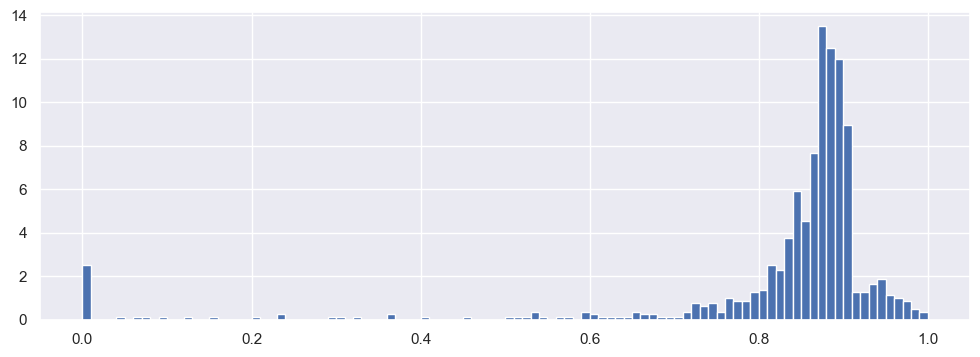

In [191]:
matching_stats.avg_matches.hist(bins=100, figsize=(12,4), density=True);

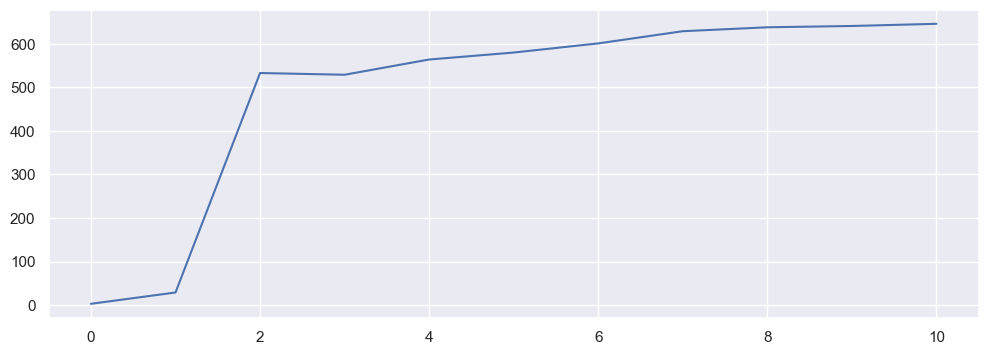

In [193]:
(matching_stats==1).drop('avg_matches', axis=1).sum().plot(figsize=(12,4));


Length Tolerance:  0


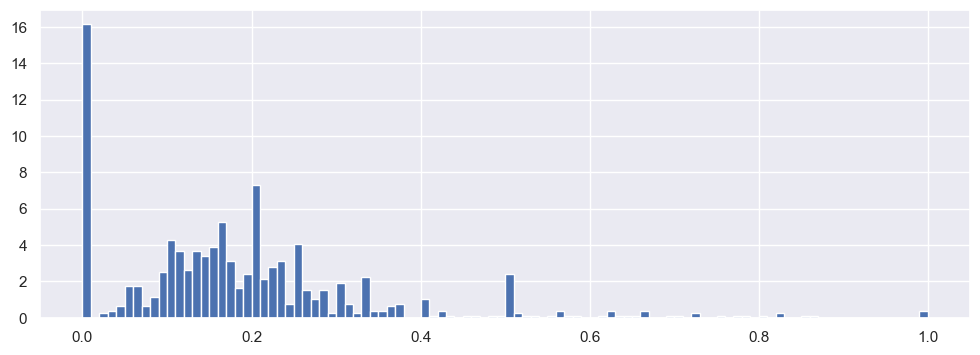


Length Tolerance:  1


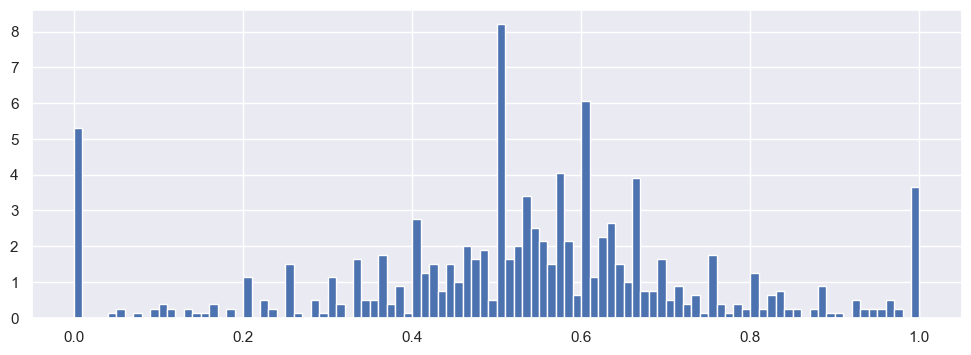


Length Tolerance:  2


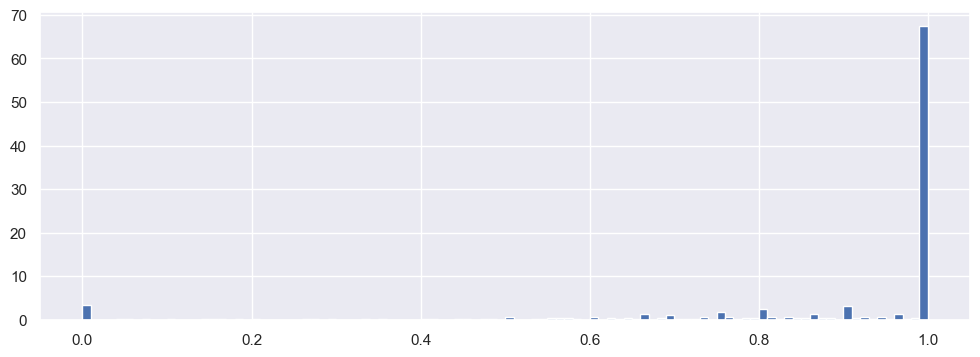

In [197]:
for i in [0,1,2]:
    print('\nLength Tolerance: ', i)
    matching_stats[i].hist(bins=100, figsize=(12,4), density=True)
    plt.show()

# NO SPEC AT ALL
# none of these fish could be double counted

In [73]:
type_counts[type_counts.spec_count.isna()]

,sample_id,hist_count,spec_count
0,4390,34,<NA>
1,4391,14,<NA>
2,4392,13,<NA>
3,4393,3,<NA>
4,4394,21,<NA>
5,4395,17,<NA>
6,4396,9,<NA>
7,4397,23,<NA>
8,4398,19,<NA>
9,4399,6,<NA>


# MORE HIST THAN SPEC
## how do we figure out which are double counted (if any)?

In [74]:
type_counts[type_counts.hist_count > type_counts.spec_count]

,sample_id,hist_count,spec_count
189,5246,22,7
205,5266,14,2
208,5270,20,3
209,5271,30,5
267,5348,11,10
276,5357,20,2
451,7532,17,6
747,7857,51,32


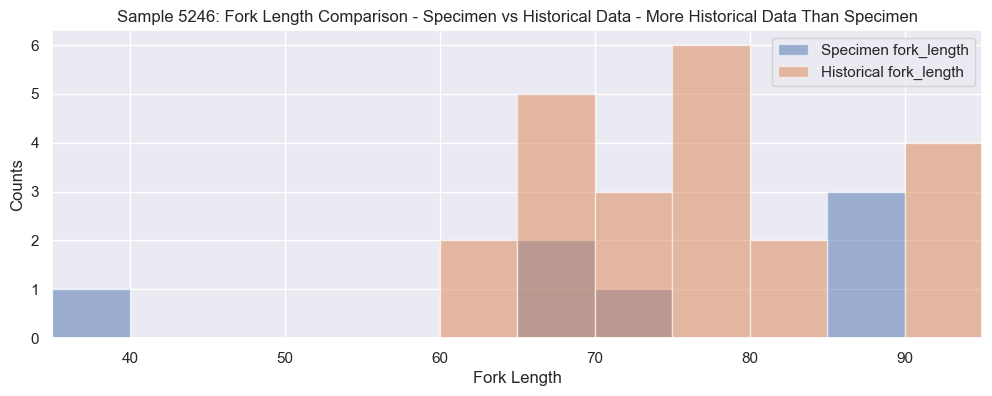

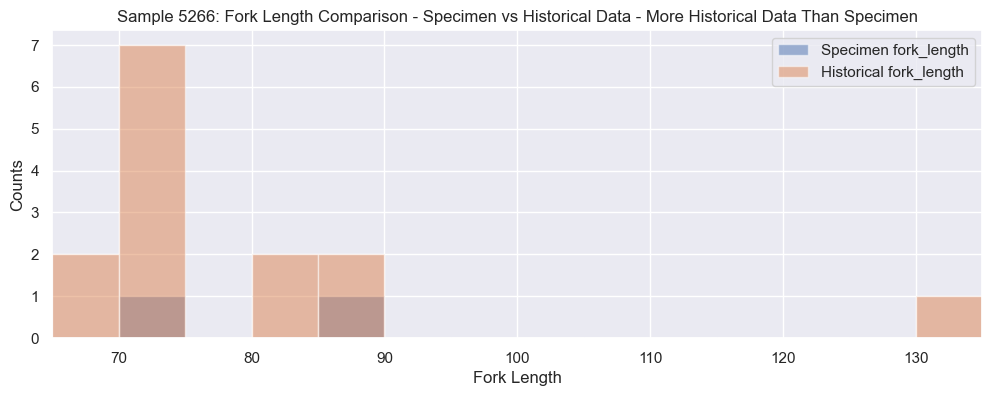

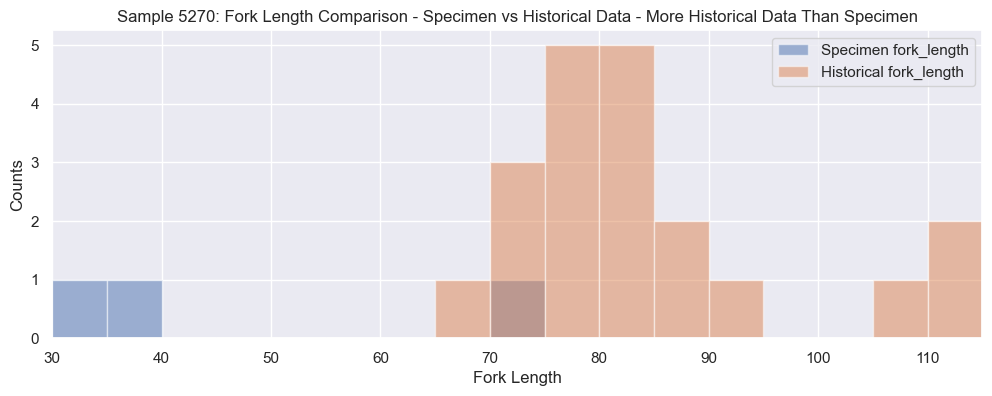

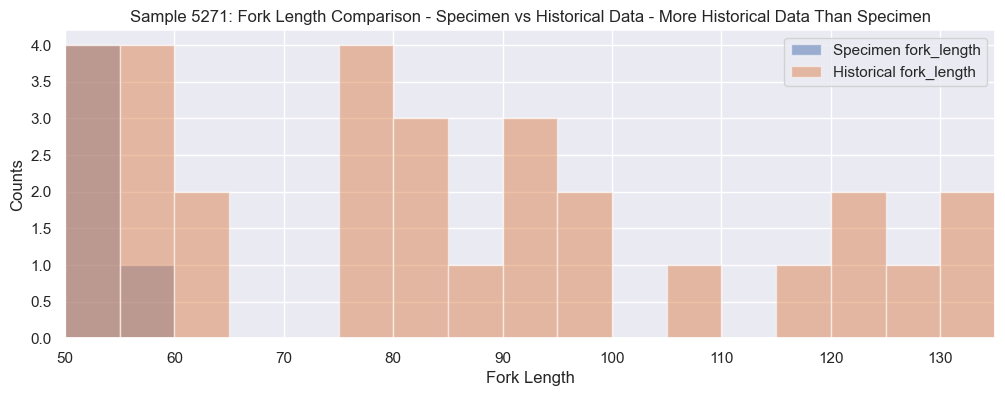

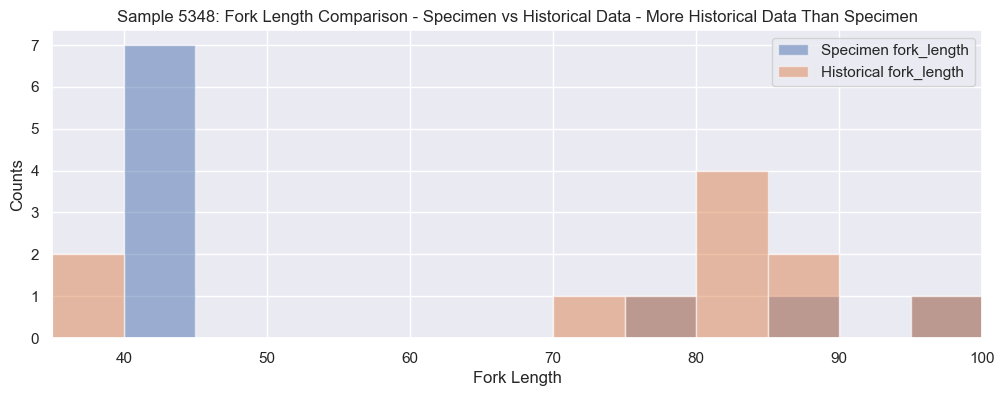

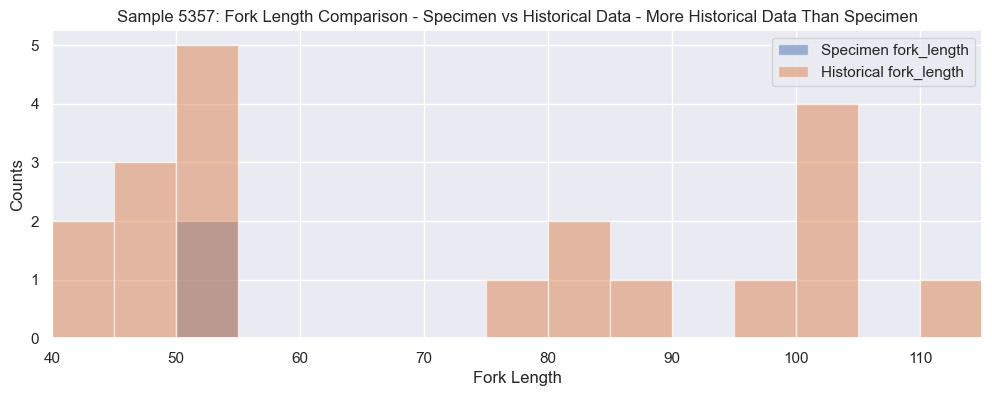

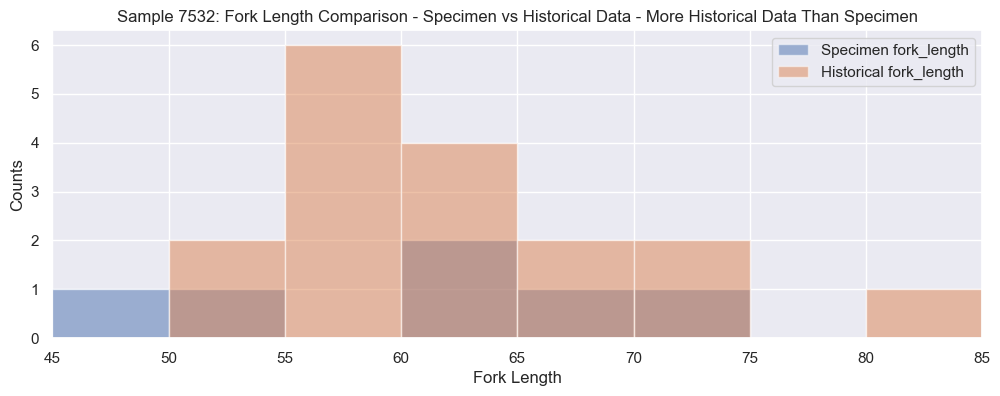

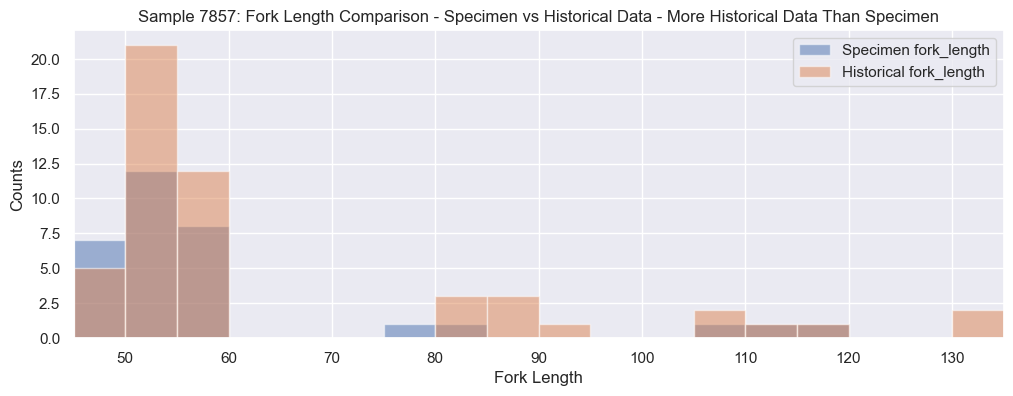

In [75]:
for i in list(type_counts[type_counts.hist_count > type_counts.spec_count].sample_id):
    plot_matching_feature_by_sample(df_spec, df_hist, i, 'fork_length', subtitle='More Historical Data Than Specimen')

# what about strong matches?
### how many of these were in the exact matches?

# import v3 includes lists of fish and samples
### all have since been removed

In [76]:
specimens_to_delete = [
    2159167, 2159168, 2159169, 2159170, 2159171, 2159172, 2159173, 2159174, 2159175, 2159176, 2159177, 2159178, 2157988, 2157986,
    2157993, 2159034, 2159035, 2159037, 2159038, 2158660, 2158661, 2158663, 2158239, 2158240, 2158245, 2157919, 2157921, 2157926,
    2159408, 2159413, 2159418, 2158856, 2158858, 2158867, 2158325, 2158329, 2158334, 2157741, 2157742, 2157757, 2159297, 2159298,
    2159308, 2159256, 2159258, 2159259, 2159261, 2158924, 2158926, 2158928, 2158155, 2158158, 2158163, 2157505, 2157506, 2157521,
]

samples_to_clean = [9350, 9341, 9349, 9346, 9343, 9340, 9354, 9347, 9344, 9339, 9353, 9352, 9348, 9345, 9342, 9338]
criteria_to_clean = {'SPECIES_ITIS_CODE': 161996, 'smart_river_age': None}

In [77]:
# should these have been deleted as well? 
df_spec[df_spec.smart_river_age.isnull()]

,id,fork_length,weight,river_age,notes,sample_id,sex_id,status_id,age_type,sweep_id,life_stage_id,old_id,smart_river_age,smart_river_age_type,matching_id
13645,2270456,<NA>,NaN,NaN,None,5254,<NA>,5.000,NaN,4068.000,3.000,GD_32914,NaN,NaN,525400_00
13646,2270457,<NA>,NaN,NaN,None,5254,<NA>,5.000,NaN,4068.000,3.000,GD_32914,NaN,NaN,525400_00


In [78]:
df_spec[df_spec.id.isin(specimens_to_delete)]

,id,fork_length,weight,river_age,notes,sample_id,sex_id,status_id,age_type,sweep_id,life_stage_id,old_id,smart_river_age,smart_river_age_type,matching_id


In [79]:
df_spec[df_spec.sample_id.isin(samples_to_clean)]

,id,fork_length,weight,river_age,notes,sample_id,sex_id,status_id,age_type,sweep_id,life_stage_id,old_id,smart_river_age,smart_river_age_type,matching_id


# differences between tables

In [80]:
# missing from specimen and in historical
[x for x in df_hist.columns if x not in df_spec.columns]

['total_length']

In [81]:
# missing from historical and in specimen
[x for x in df_spec.columns if x not in df_hist.columns]

['sweep_id', 'smart_river_age', 'smart_river_age_type']

In [82]:
# non-null total length data - could go into notes
sum(df_hist.total_length.notnull())

1663

In [83]:
# how does fork length compare to total length>?
(df_hist[df_hist.total_length.notnull()].total_length / df_hist[df_hist.total_length.notnull()].fork_length).describe()

count   1643.000
mean       1.067
std        0.019
min        0.966
25%        1.054
50%        1.067
75%        1.078
max        1.180
dtype: float64

# Check a few entries in dm_apps
* what I've checked looks correct

In [84]:
list_of_samples = list(df_hist.sample_id.unique())

if False:
    rand_sample = np.random.choice(list_of_samples)

    print('\n', f'http://127.0.0.1:8000/en/trapnet/samples/{rand_sample}/view/')

    display(
        df_spec[df_spec.sample_id==rand_sample]
        .groupby('old_id')
        .count()[['id']]
        .rename({'id':'counts'}, axis=1)
        .sort_values('counts', ascending=False)
        .head()
    )

    display(all_fish[all_fish.sample_id==rand_sample])